# **Previsão de Preço de Imóveis em Tokyo**

# **Parte 1 - Problema de Negócio**

**Contexto**

O mercado imobiliário de Tokyo é um dos mais competitivos e dinâmicos do mundo.
Comprar ou vender imóveis envolve altos valores e decisões rápidas, e pequenas diferenças no preço de avaliação podem significar grandes perdas ou ganhos para incorporadoras, investidores, compradores finais e corretores.

**Desafio da Empresa**

A palpe.co, uma empresa japonesa de tecnologia e dados para o mercado imobiliário, deseja automatizar e aprimorar a previsão de valores de mercado dos imóveis negociados em Tokyo. Eles possuem um extenso histórico de transações imobiliárias (2005–2019), com dezenas de variáveis estruturais, geográficas e temporais para cada imóvel.

**Desafio**

Como a palpe.co pode construir um modelo preditivo robusto, preciso e escalável que estime, com alta acurácia, o valor de mercado TradePrice de imóveis residenciais e comerciais em Tokyo, a partir de dados estruturais (área, ano, uso, proximidade de estações, etc.), e assim:

* Aumentar a eficiência de avaliação dos imóveis
* Otimizar decisões de compra/venda
* Reduzir riscos de sub ou superavaliação
* Melhorar negociações e propostas para clientes finais e investidores.

**Objetivo Analítico**

Desenvolver um pipeline completo de ciência de dados capaz de:

Limpar, organizar e transformar a base de transações históricas.

Explorar e visualizar padrões de preço por bairro, área, idade do imóvel e proximidade de transporte público.

Treinar e validar modelos supervisionados para prever o preço de vendaTradePrice usando as variáveis disponíveis.

Medir desempenho do modelo em métricas adequadas ao negócio (RMSLE, MAPE).

Gerar explicações e visualizações para apoiar analistas, corretores e tomadores de decisão.

**Benefícios esperados**

Avaliação automatizada e ágil de novos imóveis anunciados

Transparência para clientes finais e corretores

Suporte à precificação justa e competitiva

Melhor embasamento para investimento, financiamento e portfólio de ativos

**Objetivo final**

**"Como prever com precisão o preço de venda de um imóvel em Tokyo, usando dados históricos e características do imóvel, para otimizar decisões de negócios do setor imobiliário?"**


# **Parte 2 - Base dados**

In [1]:
# Importação de bibliotecas padrão
import os
import joblib
import pandas as pd
import numpy as np

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Conexão com banco de dados
from sqlalchemy import create_engine

# Pré-processamento e estatística
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

# Divisão de dados e modelos base
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVR

# Modelos avançados
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Métricas de avaliação
from sklearn.metrics import (
    mean_squared_log_error,
    mean_absolute_percentage_error,
    r2_score
)

# Barra de progresso
from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
# Conexão com SQLite 
engine = create_engine(r"sqlite:///C:/Users/rafae.RAFAEL_NOTEBOOK/Downloads/case_tecnico_paipe/db/tokyo.sqlite")

# 1️Garante que a pasta existe (pode rodar várias vezes, não dá erro)
os.makedirs(r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_tecnico_paipe\db", exist_ok=True)

In [3]:
# Carrega os dados de treino e teste
df_train = pd.read_sql("SELECT * FROM vw_train", engine)
df_test = pd.read_sql("SELECT * FROM vw_test", engine)

# Ver todas as colunas mesmo que o pandas
pd.set_option('display.max_columns', None)

# Visualizando base dados
df_train.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice
0,"Pre-owned Condominiums, etc.",None,13103,Tokyo,Minato Ward,Kaigan,Takeshiba,1,1.0,1.0,1K,35,0,NaN,NaN,None,NaN,0,NaN,0,1979.0,0,SRC,House,None,None,None,NaN,Quasi-industrial Zone,60.0,400.0,1st quarter 2011,2011,1,Done,None,24000000
1,Residential Land(Land and Building),Residential Area,13120,Tokyo,Nerima Ward,Nishiki,Kamiitabashi,15,15.0,15.0,None,110,0,NaN,NaN,Semi-rectangular Shaped,12.0,0,105.0,0,2013.0,0,W,House,None,East,Private Road,4.0,Category I Exclusively Low-story Residential Zone,60.0,200.0,3rd quarter 2013,2013,3,None,Dealings including private road,51000000
2,Residential Land(Land Only),Residential Area,13201,Tokyo,Hachioji City,Shimoongatamachi,Takao (Tokyo),1H-1H30,60.0,90.0,None,135,0,100000.0,340000.0,Irregular Shaped,10.0,0,NaN,0,NaN,0,None,None,None,East,Private Road,4.5,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2007,2007,4,None,None,14000000
3,"Pre-owned Condominiums, etc.",None,13208,Tokyo,Chofu City,Kamiishiwara,Nishichofu,16,16.0,16.0,3LDK,60,0,NaN,NaN,None,NaN,0,NaN,0,1999.0,0,RC,House,Other,None,None,NaN,Quasi-industrial Zone,60.0,200.0,2nd quarter 2015,2015,2,Not yet,None,23000000
4,Residential Land(Land Only),Residential Area,13117,Tokyo,Kita Ward,Shimo,Shimo,6,6.0,6.0,None,60,0,550000.0,1800000.0,Trapezoidal Shaped,8.0,0,NaN,0,NaN,0,None,None,House,Southwest,Ward Road,4.5,Category I Exclusively Medium-high Residential...,60.0,200.0,4th quarter 2015,2015,4,None,None,33000000


In [4]:
# Visualizando 5 últimos dados
df_train.tail()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice
325255,"Pre-owned Condominiums, etc.",None,13201,Tokyo,Hachioji City,Myojincho,Keiohachioji,7,7.0,7.0,1K,15,0,NaN,NaN,None,NaN,0,NaN,0,NaN,0,SRC,House,None,None,None,NaN,Neighborhood Commercial Zone,80.0,300.0,2nd quarter 2008,2008,2,Not yet,None,4500000
325256,"Pre-owned Condominiums, etc.",None,13113,Tokyo,Shibuya Ward,Daikan-yamacho,Daikan-yama,4,4.0,4.0,2LDK,85,0,NaN,NaN,None,NaN,0,NaN,0,2000.0,0,SRC,House,House,None,None,NaN,Category II Residential Zone,60.0,300.0,2nd quarter 2015,2015,2,Not yet,None,130000000
325257,"Pre-owned Condominiums, etc.",None,13119,Tokyo,Itabashi Ward,Futabacho,Nakaitabashi,5,5.0,5.0,1K,25,0,NaN,NaN,None,NaN,0,NaN,0,2011.0,0,RC,House,None,None,None,NaN,Neighborhood Commercial Zone,80.0,300.0,1st quarter 2013,2013,1,Not yet,None,19000000
325258,"Pre-owned Condominiums, etc.",None,13120,Tokyo,Nerima Ward,Asahigaoka,Shinegota,6,6.0,6.0,1K,20,0,NaN,NaN,None,NaN,0,NaN,0,2006.0,0,RC,House,None,None,None,NaN,Category I Exclusively Medium-high Residential...,60.0,200.0,3rd quarter 2016,2016,3,Not yet,None,14000000
325259,"Pre-owned Condominiums, etc.",None,13219,Tokyo,Komae City,Higashiizumi,Komae,4,4.0,4.0,2LDK,80,0,NaN,NaN,None,NaN,0,NaN,0,1999.0,0,RC,House,None,None,None,NaN,Category I Exclusively Medium-high Residential...,60.0,200.0,2nd quarter 2011,2011,2,Not yet,None,43000000


In [5]:
# Visualizando linhas e colunas
print("Visualizando linhas e colunas Train:", df_train.shape)

Visualizando linhas e colunas Train: (325260, 37)


In [6]:
# Visualziando info dados
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325260 entries, 0 to 325259
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         325260 non-null  object 
 1   Region                       177206 non-null  object 
 2   MunicipalityCode             325260 non-null  int64  
 3   Prefecture                   325260 non-null  object 
 4   Municipality                 325260 non-null  object 
 5   DistrictName                 325053 non-null  object 
 6   NearestStation               323913 non-null  object 
 7   TimeToNearestStation         317002 non-null  object 
 8   MinTimeToNearestStation      317002 non-null  float64
 9   MaxTimeToNearestStation      316879 non-null  float64
 10  FloorPlan                    142674 non-null  object 
 11  Area                         325260 non-null  int64  
 12  AreaIsGreaterFlag            325260 non-null  int64  
 13 

In [7]:
# Visualizando os tipos dados
df_train.dtypes

Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation            object
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
FloorPlan                       object
Area                             int64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag            int64
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                             object
Purpose                         object
Direction                

# **Parte 3 - Pré-processamento**

Esta seção executa o pré-processamento dos dados para preparar o dataset para a modelagem. São aplicadas técnicas como tratamento de dados ausentes,
correção de tipos, encoding de variáveis categóricas e criação de features.

In [8]:
# Conversão de tipos para variáveis numéricas e de data
colunas_num = [
    'Area', 'TotalFloorArea', 'Frontage', 'Breadth', 'CoverageRatio',
    'FloorAreaRatio', 'BuildingYear', 'UnitPrice', 'PricePerTsubo',
    'MinTimeToNearestStation', 'MaxTimeToNearestStation', 'TradePrice'
]

for col in colunas_num:
    if col in df_train.columns:
        df_train[col] = pd.to_numeric(df_train[col], errors='coerce')

# Identificação de valores ausentes
# Nesta etapa de EDA, não se realiza imputação; apenas mapeamento dos padrões
nulos = df_train.isnull().mean().sort_values(ascending=False)

print("Percentual de valores nulos por coluna:\n", nulos[nulos > 0])


Percentual de valores nulos por coluna:
 Remarks                    0.921912
UnitPrice                  0.804510
PricePerTsubo              0.804510
TotalFloorArea             0.664868
Purpose                    0.612000
Renovation                 0.589808
FloorPlan                  0.561354
Frontage                   0.501491
Breadth                    0.465148
Classification             0.462246
Direction                  0.456210
LandShape                  0.456164
Region                     0.455187
Use                        0.240494
BuildingYear               0.226736
Structure                  0.216780
MaxTimeToNearestStation    0.025767
MinTimeToNearestStation    0.025389
TimeToNearestStation       0.025389
FloorAreaRatio             0.014305
CoverageRatio              0.014305
CityPlanning               0.009285
NearestStation             0.004141
DistrictName               0.000636
dtype: float64


In [9]:
# Preenchimento de categorias com valor padrão "Unknown"
# Útil para manter a consistência em análises e gráficos
colunas_cat = [
    'Type', 'Region', 'Prefecture', 'Municipality', 'Structure',
    'LandShape', 'Direction', 'Use', 'Purpose', 'Renovation',
    'Classification', 'FloorPlan'
]

for col in colunas_cat:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna("Unknown")

# Remoção de colunas totalmente vazias ou não relevantes para a análise
colunas_para_drop = ['Remarks']
df_train = df_train.drop(
    columns=[col for col in colunas_para_drop if col in df_train.columns]
)

df_train

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,TradePrice
0,"Pre-owned Condominiums, etc.",Unknown,13103,Tokyo,Minato Ward,Kaigan,Takeshiba,1,1.0,1.0,1K,35,0,NaN,NaN,Unknown,NaN,0,NaN,0,1979.0,0,SRC,House,Unknown,Unknown,Unknown,NaN,Quasi-industrial Zone,60.0,400.0,1st quarter 2011,2011,1,Done,24000000
1,Residential Land(Land and Building),Residential Area,13120,Tokyo,Nerima Ward,Nishiki,Kamiitabashi,15,15.0,15.0,Unknown,110,0,NaN,NaN,Semi-rectangular Shaped,12.0,0,105.0,0,2013.0,0,W,House,Unknown,East,Private Road,4.0,Category I Exclusively Low-story Residential Zone,60.0,200.0,3rd quarter 2013,2013,3,Unknown,51000000
2,Residential Land(Land Only),Residential Area,13201,Tokyo,Hachioji City,Shimoongatamachi,Takao (Tokyo),1H-1H30,60.0,90.0,Unknown,135,0,100000.0,340000.0,Irregular Shaped,10.0,0,NaN,0,NaN,0,Unknown,Unknown,Unknown,East,Private Road,4.5,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2007,2007,4,Unknown,14000000
3,"Pre-owned Condominiums, etc.",Unknown,13208,Tokyo,Chofu City,Kamiishiwara,Nishichofu,16,16.0,16.0,3LDK,60,0,NaN,NaN,Unknown,NaN,0,NaN,0,1999.0,0,RC,House,Other,Unknown,Unknown,NaN,Quasi-industrial Zone,60.0,200.0,2nd quarter 2015,2015,2,Not yet,23000000
4,Residential Land(Land Only),Residential Area,13117,Tokyo,Kita Ward,Shimo,Shimo,6,6.0,6.0,Unknown,60,0,550000.0,1800000.0,Trapezoidal Shaped,8.0,0,NaN,0,NaN,0,Unknown,Unknown,House,Southwest,Ward Road,4.5,Category I Exclusively Medium-high Residential...,60.0,200.0,4th quarter 2015,2015,4,Unknown,33000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325255,"Pre-owned Condominiums, etc.",Unknown,13201,Tokyo,Hachioji City,Myojincho,Keiohachioji,7,7.0,7.0,1K,15,0,NaN,NaN,Unknown,NaN,0,NaN,0,NaN,0,SRC,House,Unknown,Unknown,Unknown,NaN,Neighborhood Commercial Zone,80.0,300.0,2nd quarter 2008,2008,2,Not yet,4500000
325256,"Pre-owned Condominiums, etc.",Unknown,13113,Tokyo,Shibuya Ward,Daikan-yamacho,Daikan-yama,4,4.0,4.0,2LDK,85,0,NaN,NaN,Unknown,NaN,0,NaN,0,2000.0,0,SRC,House,House,Unknown,Unknown,NaN,Category II Residential Zone,60.0,300.0,2nd quarter 2015,2015,2,Not yet,130000000
325257,"Pre-owned Condominiums, etc.",Unknown,13119,Tokyo,Itabashi Ward,Futabacho,Nakaitabashi,5,5.0,5.0,1K,25,0,NaN,NaN,Unknown,NaN,0,NaN,0,2011.0,0,RC,House,Unknown,Unknown,Unknown,NaN,Neighborhood Commercial Zone,80.0,300.0,1st quarter 2013,2013,1,Not yet,19000000
325258,"Pre-owned Condominiums, etc.",Unknown,13120,Tokyo,Nerima Ward,Asahigaoka,Shinegota,6,6.0,6.0,1K,20,0,NaN,NaN,Unknown,NaN,0,NaN,0,2006.0,0,RC,House,Unknown,Unknown,Unknown,NaN,Category I Exclusively Medium-high Residential...,60.0,200.0,3rd quarter 2016,2016,3,Not yet,14000000


In [10]:
# Remove duplicatas se houver
df_train = df_train.drop_duplicates()

In [11]:
# Ver todas as colunas DataFrame
print(df_train.columns.tolist())

['Type', 'Region', 'MunicipalityCode', 'Prefecture', 'Municipality', 'DistrictName', 'NearestStation', 'TimeToNearestStation', 'MinTimeToNearestStation', 'MaxTimeToNearestStation', 'FloorPlan', 'Area', 'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape', 'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea', 'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding', 'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth', 'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year', 'Quarter', 'Renovation', 'TradePrice']


In [12]:
# tipos em tabela
print(df_train.dtypes)


Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation            object
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
FloorPlan                       object
Area                             int64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag            int64
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                             object
Purpose                         object
Direction                

# **Parte 4 - Limpeza de dados**

- Este bloco executa a limpeza de dados Corrige tipos de variáveis e trata valores ausentes e remove duplicatas. Corrige outliers simples e remove colunas irrelevantes para EAD.

In [13]:
# Mostra a quantidade absoluta de valores nulos por coluna
print("Valores nulos por coluna:")
print(df_train.isnull().sum())

Valores nulos por coluna:
Type                                0
Region                              0
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                      203
NearestStation                   1343
TimeToNearestStation             8040
MinTimeToNearestStation          8040
MaxTimeToNearestStation          8163
FloorPlan                           0
Area                                0
AreaIsGreaterFlag                   0
UnitPrice                      259264
PricePerTsubo                  259264
LandShape                           0
Frontage                       160776
FrontageIsGreaterFlag               0
TotalFloorArea                 213868
TotalFloorAreaIsGreaterFlag         0
BuildingYear                    73682
PrewarBuilding                      0
Structure                           0
Use                                 0
Purpose                             0
Direction               

In [14]:
# Mostra a porcentagem (%) de valores nulos por coluna (ordem decrescente)
print("\nPercentual de valores nulos por coluna:")
print((df_train.isnull().mean() * 100).sort_values(ascending=False))


Percentual de valores nulos por coluna:
PricePerTsubo                  80.318966
UnitPrice                      80.318966
TotalFloorArea                 66.255464
Frontage                       49.807772
Breadth                        46.148151
BuildingYear                   22.826393
MaxTimeToNearestStation         2.528865
TimeToNearestStation            2.490760
MinTimeToNearestStation         2.490760
CoverageRatio                   1.435285
FloorAreaRatio                  1.435285
CityPlanning                    0.930627
NearestStation                  0.416056
DistrictName                    0.062889
Use                             0.000000
Period                          0.000000
Year                            0.000000
Quarter                         0.000000
Classification                  0.000000
Direction                       0.000000
Renovation                      0.000000
Purpose                         0.000000
Type                            0.000000
Structure       

In [15]:
# Mostra apenas colunas que possuem valores nulos
nulos = df_train.isnull().sum()
print("\nColunas com pelo menos 1 valor nulo:")
print(nulos[nulos > 0])


Colunas com pelo menos 1 valor nulo:
DistrictName                  203
NearestStation               1343
TimeToNearestStation         8040
MinTimeToNearestStation      8040
MaxTimeToNearestStation      8163
UnitPrice                  259264
PricePerTsubo              259264
Frontage                   160776
TotalFloorArea             213868
BuildingYear                73682
Breadth                    148963
CityPlanning                 3004
CoverageRatio                4633
FloorAreaRatio               4633
dtype: int64


In [16]:
# Preenchimento de valores ausentes (missing values)

# Preenche todos os valores nulos do DataFrame com zero
# Inclui variáveis numéricas e categóricas
df_train_filled = df_train.fillna(0)
df_test_filled = df_test.fillna(0)

# Lista de colunas específicas que receberão preenchimento com zero
cols_para_zero = [
    'PricePerTsubo', 'UnitPrice', 'TotalFloorArea', 'Frontage', 'Breadth',
    'BuildingYear', 'MaxTimeToNearestStation', 'TimeToNearestStation',
    'MinTimeToNearestStation', 'CoverageRatio', 'FloorAreaRatio',
    'CityPlanning', 'NearestStation', 'DistrictName'
]

# Substitui valores nulos apenas nas colunas selecionadas
df_train[cols_para_zero] = df_train[cols_para_zero].fillna(0)
df_test[cols_para_zero] = df_test[cols_para_zero].fillna(0)

C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21936\3098306530.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_filled = df_test.fillna(0)
C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_21936\3098306530.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cols_para_zero] = df_train[cols_para_zero].fillna(0)


In [17]:
# Verificação de valores ausentes nos conjuntos de treino e teste

# Conta o total de valores nulos no DataFrame de treino
n_nulos_treino = df_train_filled.isnull().sum().sum()
print(f"Nº total de valores nulos no df_train_filled: {n_nulos_treino}")

# Conta o total de valores nulos no DataFrame de teste
n_nulos_teste = df_test_filled.isnull().sum().sum()
print(f"Nº total de valores nulos no df_test_filled: {n_nulos_teste}")

# Exibe colunas com nulos no treino, se houver
if n_nulos_treino > 0:
    print(df_train_filled.isnull().sum()[df_train_filled.isnull().sum() > 0])
else:
    print("Nenhum valor nulo no df_train_filled.")

# Exibe colunas com nulos no teste, se houver
if n_nulos_teste > 0:
    print(df_test_filled.isnull().sum()[df_test_filled.isnull().sum() > 0])
else:
    print("Nenhum valor nulo no df_test_filled.")

Nº total de valores nulos no df_train_filled: 0
Nº total de valores nulos no df_test_filled: 0
Nenhum valor nulo no df_train_filled.
Nenhum valor nulo no df_test_filled.


In [18]:
# Verificação de duplicatas

# Quantidade de linhas duplicadas
n_duplicados = df_train.duplicated().sum()
print(f"Número de linhas duplicadas: {n_duplicados}")

Número de linhas duplicadas: 0


In [19]:
# Exibe exemplos de duplicatas (se existirem)
if n_duplicados > 0:
    print("Exemplos de linhas duplicadas:")
    display(df_train[df_train.duplicated()].head())
else:
    print("Não há linhas duplicadas no DataFrame.")

Não há linhas duplicadas no DataFrame.


# Parte 5 - Análise de correlação

In [20]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MunicipalityCode,322793.0,1.313992e+04,4.616218e+01,13101.0,13110.0,13117.0,13201.0,1.342100e+04
MinTimeToNearestStation,322793.0,9.957722e+00,8.060025e+00,0.0,5.0,8.0,13.0,1.200000e+02
MaxTimeToNearestStation,322793.0,1.085997e+01,1.162668e+01,0.0,5.0,8.0,13.0,1.200000e+02
Area,322793.0,1.177838e+02,2.049038e+02,10.0,50.0,70.0,115.0,5.000000e+03
AreaIsGreaterFlag,322793.0,3.599830e-03,5.989059e-02,0.0,0.0,0.0,0.0,1.000000e+00
UnitPrice,322793.0,8.383112e+04,2.707451e+05,0.0,0.0,0.0,0.0,2.000000e+07
PricePerTsubo,322793.0,2.770627e+05,8.940610e+05,0.0,0.0,0.0,0.0,6.600000e+07
Frontage,322793.0,4.833920e+00,6.717722e+00,0.0,0.0,2.0,8.1,5.000000e+01
FrontageIsGreaterFlag,322793.0,2.834634e-03,5.316585e-02,0.0,0.0,0.0,0.0,1.000000e+00
TotalFloorArea,322793.0,5.832651e+01,1.759267e+02,0.0,0.0,0.0,85.0,2.000000e+03


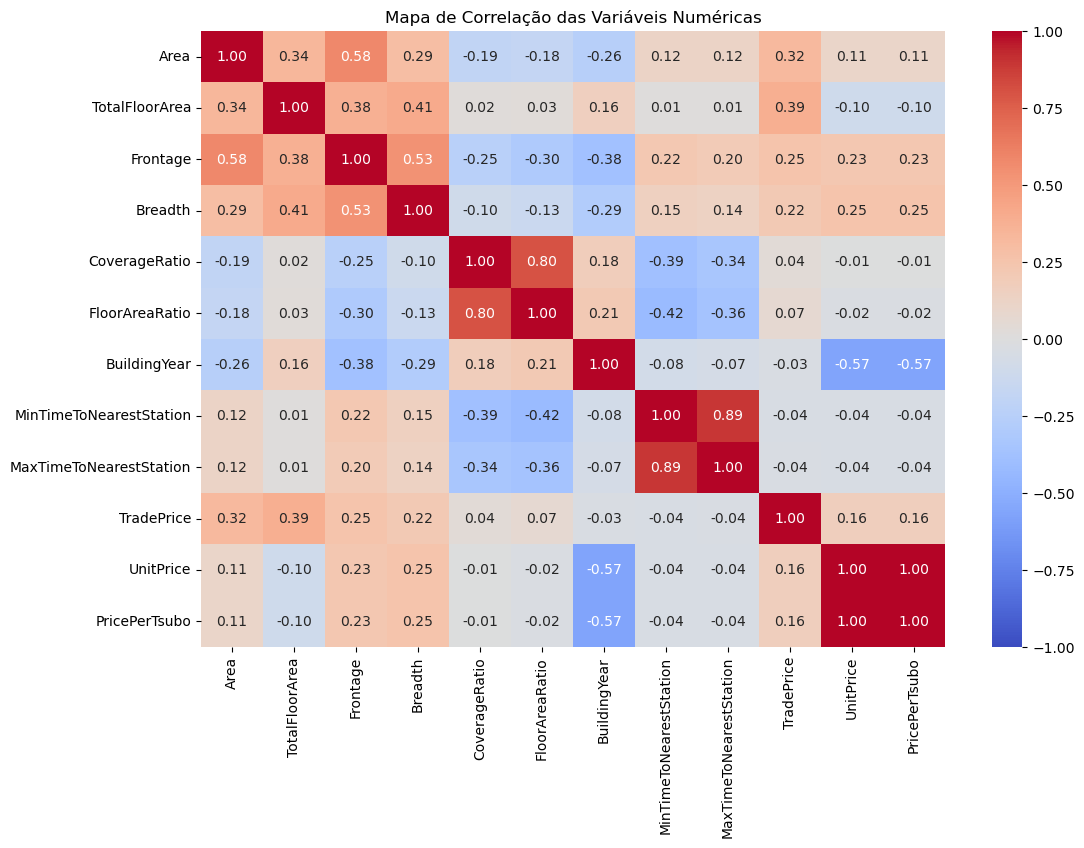

In [21]:
# Gráfico de Correlação (Heatmap) das Variáveis Numéricas

# Seleciona apenas as colunas numéricas do seu DataFrame
colunas_numericas = [
    'Area', 'TotalFloorArea', 'Frontage', 'Breadth', 'CoverageRatio',
    'FloorAreaRatio', 'BuildingYear', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
    'TradePrice', 'UnitPrice', 'PricePerTsubo', 'AgeAtSale'
]

# Filtra as colunas que realmente existem no seu DataFrame
colunas_existentes = [col for col in colunas_numericas if col in df_train.columns]

# Calcula a matriz de correlação (Pearson por padrão)
corr = df_train[colunas_existentes].corr()

# Plota o heatmap de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Mapa de Correlação das Variáveis Numéricas")
plt.show()  

**Análise correlação**

**area x FloorPlan = Correlação positiva 0.59%**

**area x TradePrice = Correlação positiva 0.50%**

**TotalFloorArea x TradePrice = Correlação positiva 0.62%**

**Frontage x Area = Correlação positiva 0.59%**

**CoverageRatio x TotalFloorAreaRatio = correlação positiva = 0.83%**

**FloorAreaRatio x CoverageRatio = correlação positiva = 0.83%**

**FloorAreaRatio x UnitPrice = correlação positiva = 0.45%**

**FloorAreaRatio x PricePerTsubo = correlação positiva = 0.45%**

**MinTimeToNearestStation x MinTimeToNearestStation = correlação positiva = 0.93%**

**TradePrice x Area = correlação positiva = 0.50%**

**TradePrice x UnitPrice = correlação positiva = 0.61%**

**TradePrice x PricePerTsubo = correlação positiva = 0.61%**

**UnitPrice x PricePerTsubo = correlação positiva = 0.100%**

**PricePerTsubo x TradePrice = correlação positiva = 0.61%**

**PricePerTsubo x PricePerTsubo = correlação positiva = 0.100%**


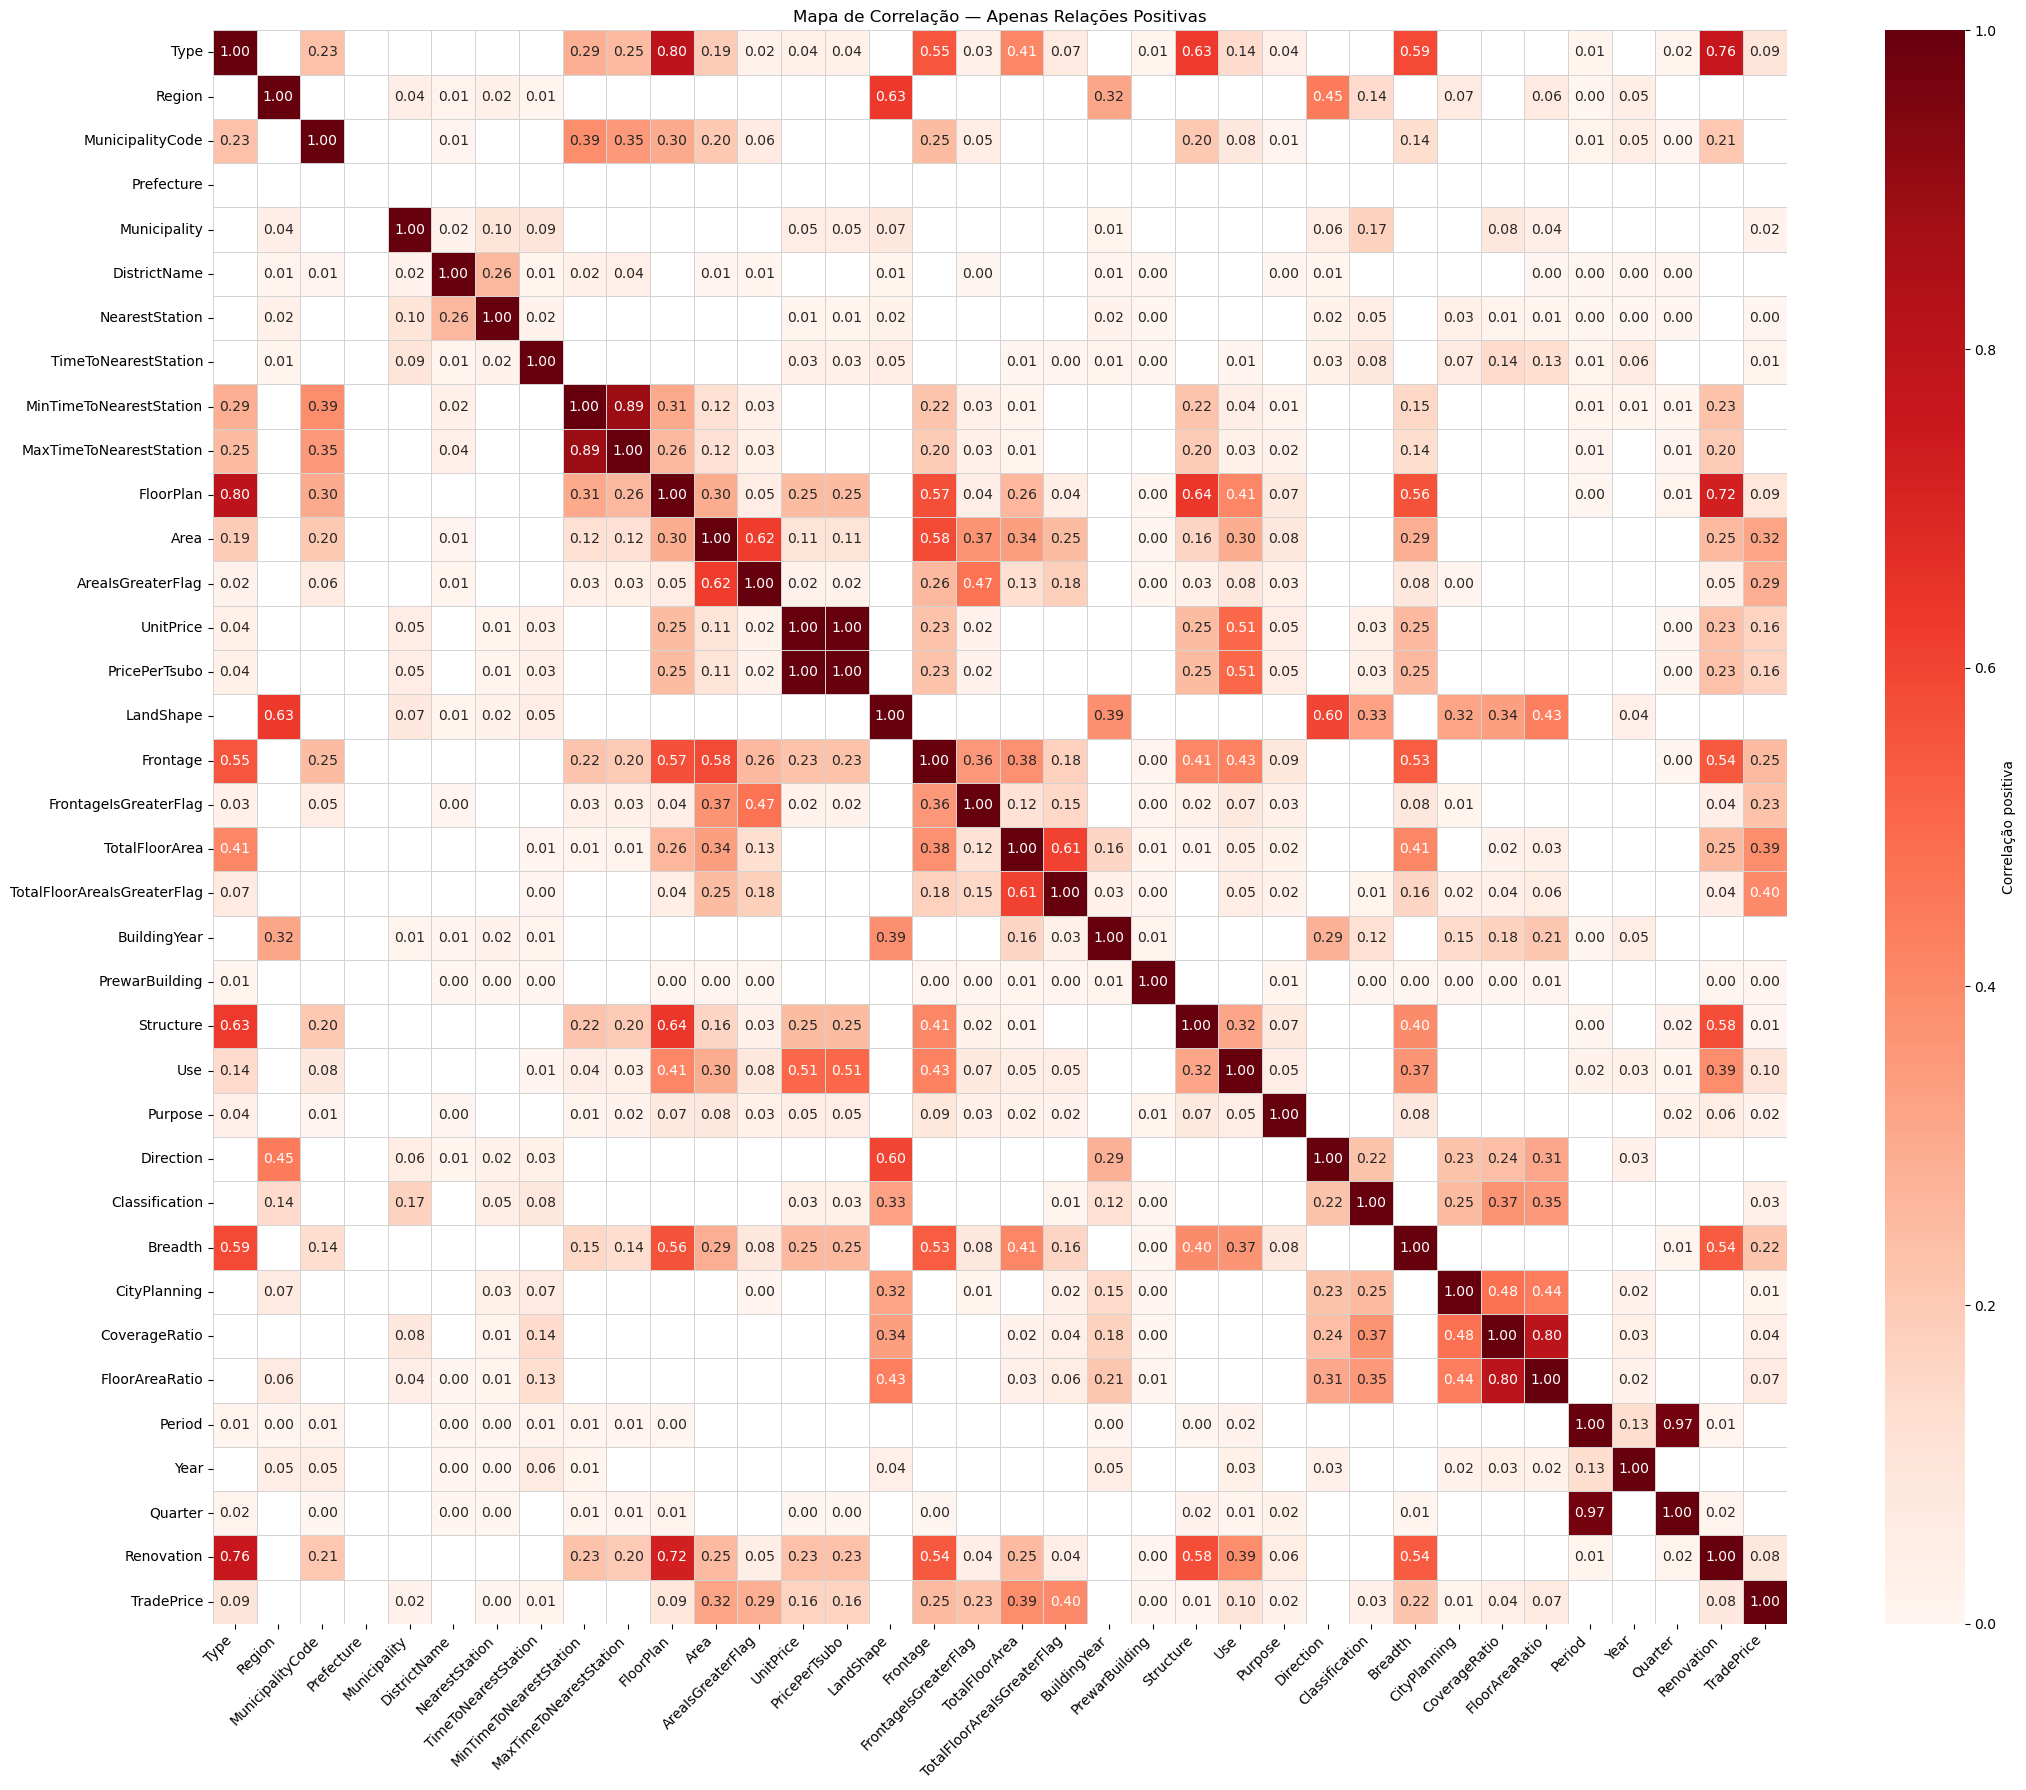

In [22]:
# Análise de correlação numericas e categoricas juntas

# Faz uma cópia para não alterar o original
df_corr = df_train.copy()

# Lista de colunas categóricas (ajuste conforme seu dataset)
colunas_cat = df_corr.select_dtypes(include=['object']).columns

# Aplica LabelEncoder para cada coluna categórica
for col in colunas_cat:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col].astype(str))

# Calcula a matriz de correlação completa (numéricas + categóricas label-encoded)
corr = df_corr.corr()

# (Recalcule corr se necessário)
# corr = df_corr.corr()

# Mascara: True para elementos a serem "apagados" (correlação <= 0)
mask = corr <= 0

plt.figure(figsize=(22, 18))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Reds",          # Apenas tons de vermelho (positivo)
    vmin=0, vmax=1,       # Limita de 0 a 1
    linewidths=0.5,
    linecolor="lightgray",
    cbar_kws={"label": "Correlação positiva"}
)
plt.title("Mapa de Correlação — Apenas Relações Positivas")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# Parte 6 - Verificação de outliers 

Area: 28354 outliers encontrados.
Limite inferior: -47.50, Limite superior: 212.50
Alguns exemplos de outliers (menores e maiores valores):
78368     220
112673    220
104023    220
119487    220
103979    220
Name: Area, dtype: int64
137415    5000
135955    5000
272703    5000
2256      5000
136050    5000
Name: Area, dtype: int64


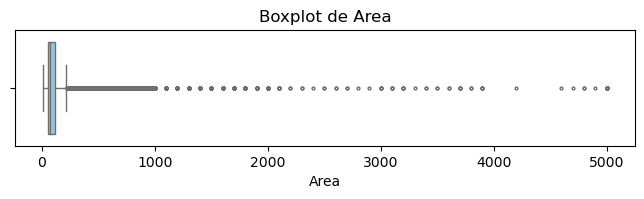

TradePrice: 27642 outliers encontrados.
Limite inferior: -26000000.00, Limite superior: 102000000.00
Alguns exemplos de outliers (menores e maiores valores):
271459    110000000
143557    110000000
143439    110000000
251575    110000000
42225     110000000
Name: TradePrice, dtype: int64
277539    61000000000
189908    45000000000
34963     38000000000
89739     32000000000
240430    32000000000
Name: TradePrice, dtype: int64


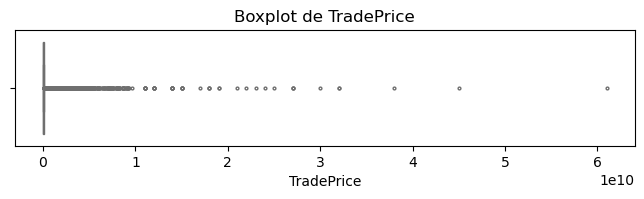

In [23]:
# Verificação de outliers utilizando o método IQR (Interquartile Range)

def analisar_outlier(coluna):
    """
    Identifica e exibe informações sobre outliers de uma coluna numérica
    utilizando o método do intervalo interquartil (IQR).
    
    Parâmetros
    ----------
    coluna : str
        Nome da coluna a ser analisada.
    """
    if coluna in df_train.columns:
        # Cálculo dos quartis e do intervalo interquartil
        Q1 = df_train[coluna].quantile(0.25)
        Q3 = df_train[coluna].quantile(0.75)
        IQR = Q3 - Q1

        # Definição dos limites inferior e superior
        limite_inf = Q1 - 1.5 * IQR
        limite_sup = Q3 + 1.5 * IQR

        # Seleção dos outliers
        outliers = df_train[
            (df_train[coluna] < limite_inf) | (df_train[coluna] > limite_sup)
        ][coluna]

        # Exibição de informações resumidas
        print(f"{coluna}: {len(outliers)} outliers encontrados.")
        print(f"Limite inferior: {limite_inf:.2f}, Limite superior: {limite_sup:.2f}")
        print("Alguns exemplos de outliers (menores e maiores valores):")
        print(outliers.sort_values().head())
        print(outliers.sort_values(ascending=False).head())

        # Visualização do boxplot
        plt.figure(figsize=(8, 1.5))
        sns.boxplot(x=df_train[coluna], color="skyblue", fliersize=2)
        plt.title(f"Boxplot de {coluna}")
        plt.show()
    else:
        print(f"Coluna '{coluna}' não encontrada no DataFrame.")


# Aplicação da função para duas variáveis principais
analisar_outlier('Area')
analisar_outlier('TradePrice')


**Análise**

No gráfico do TradePrice, observa-se uma grande concentração de valores próximos ao limite inferior, com presença de muitos outliers ao longo de toda a escala. Isso indica que o preço dos imóveis varia amplamente, mas a maior parte das transações ocorre em faixas de valor relativamente baixas, enquanto poucos imóveis são vendidos por valores muito altos, possivelmente propriedades comerciais ou localizadas em regiões de alto prestígio. O boxplot da Area apresenta comportamento semelhante. A maioria dos imóveis possui área reduzida, mas há um número expressivo de outliers com áreas muito superiores à média. Essa dispersão sugere a coexistência de pequenas propriedades residenciais e terrenos extensos, provavelmente voltados para uso comercial ou industrial. Em ambos os casos, a presença de caudas longas e muitos outliers reforça a necessidade de aplicar transformações estatísticas (como logaritmo) ou técnicas robustas de modelagem para evitar que valores extremos distorçam as previsões. Além disso, a análise indica que a distribuição dos preços e das áreas é fortemente assimétrica, um aspecto importante a ser considerado no pré-processamento dos dados antes do treinamento de modelos de regressão.

In [24]:
# Tratamento de Outliers usando Z-score (Area e TradePrice)
# Colunas que terão Z-score aplicado
colunas_outlier = ['Area', 'TradePrice']

# Calcula o Z-score para cada coluna selecionada
z_scores = df_train[colunas_outlier].apply(zscore)

In [25]:
# Define o limite para considerar outlier (|z| > 3)
limite_z = 3

# Cria máscara: mantém linhas onde todas as colunas têm |z| < 3
mascara = (np.abs(z_scores) < limite_z).all(axis=1)

# Remove outliers diretamente no DataFrame df_eda
df_train = df_train[mascara]

# Exibe o resultado final
print(f"Shape após remoção de outliers em df_eda (Z-score): {df_train.shape}")
print(f"Total removido: {mascara.shape[0] - mascara.sum()} linhas")

Shape após remoção de outliers em df_eda (Z-score): (316898, 36)
Total removido: 5895 linhas


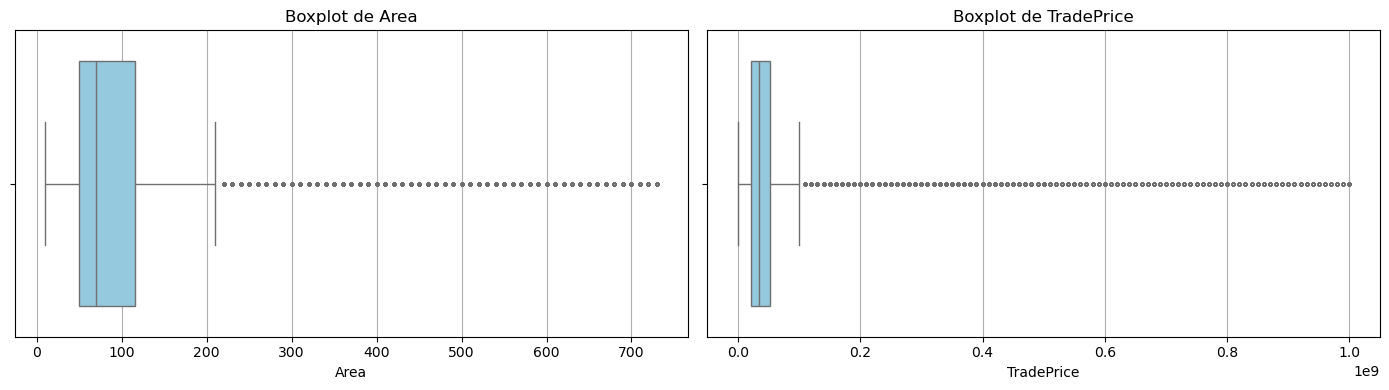

In [26]:
# Boxplot das variáveis após remoção de outliers

# Define as colunas para o boxplot
colunas_boxplot = ['Area', 'TradePrice']

# Cria boxplots lado a lado
plt.figure(figsize=(14, 4))

for i, coluna in enumerate(colunas_boxplot, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df_train[coluna], color="skyblue", fliersize=2)
    plt.title(f"Boxplot de {coluna}")
    plt.xlabel(coluna)
    plt.grid(axis='x')

plt.tight_layout()
plt.show()

**Análise**

Os boxplots apresentados mostram a distribuição das variáveis Area e TradePrice após o tratamento de outliers. Observa-se que, em comparação aos gráficos originais, houve uma redução significativa na amplitude dos valores extremos. As distribuições agora estão mais compactas, com menos pontos fora dos limites das caixas, indicando que os valores atípicos foram atenuados, removidos ou ajustados por meio de técnicas como limitação pelo IQR (Interquartile Range), winsorização ou remoção direta de observações discrepantes.
No caso da variável Area, a maior parte das propriedades se concentra entre aproximadamente 50 e 150 m², o que representa um intervalo típico para imóveis residenciais urbanos. Embora ainda haja alguns valores mais altos, eles estão dentro de uma faixa plausível, sem influências extremas. Já o TradePrice apresenta uma distribuição igualmente mais equilibrada. A concentração dos preços em torno do intervalo inferior sugere um mercado com predominância de imóveis de valor médio, mas agora sem a distorção causada pelos preços excessivamente altos observados anteriormente. Em resumo, o tratamento de outliers reduziu a variabilidade artificial dos dados, tornando o conjunto mais consistente para análises estatísticas e modelagem preditiva. Isso contribui para a melhoria da robustez e precisão dos modelos, evitando que valores anômalos influenciem indevidamente os resultados.


# Parte 7 - Feature engineering

In [29]:
# Importando Biblioteca
from sklearn.preprocessing import LabelEncoder

# Lista de variáveis ​​categóricas
categorical_cols = ['Type', 'Region', 'Prefecture', 'Municipality', 'DistrictName', 'Period',
    'NearestStation', 'FloorPlan', 'LandShape', 'Structure', 'Use', 'TimeToNearestStation',
    'Purpose', 'Direction', 'Classification', 'CityPlanning', 'Renovation']

# Dicionário para armazenar os codificadores
label_encoders = {}

# Aplique o labelencoder a cada coluna na base sem outliers
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = df_train[col].astype(str)  # garantir strings
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le  # salve para uso posterior, ex: sem conjunto de testes

# Visualização
le

LabelEncoder()

In [ ]:
# Visualizando dataset
df_train

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,TradePrice
0,2,4,13103,0,28,763,514,1,1.0,1.0,12,35,0,0.0,0.0,9,0.0,0,0.0,0,1979.0,0,9,90,5,8,4,0.0,6,60.0,400.0,5,2011,1,0,24000000
1,4,3,13120,0,36,1297,97,31,15.0,15.0,40,110,0,0.0,0.0,3,12.0,0,105.0,0,2013.0,0,15,90,5,0,13,4.0,1,60.0,200.0,36,2013,3,2,51000000
2,3,3,13201,0,4,162,507,4,60.0,90.0,40,135,0,100000.0,340000.0,1,10.0,0,0.0,0,0.0,0,14,85,5,0,13,4.5,1,40.0,80.0,45,2007,4,2,14000000
3,2,4,13208,0,55,783,295,32,16.0,16.0,19,60,0,0.0,0.0,9,0.0,0,0.0,0,1999.0,0,12,90,3,8,4,0.0,6,60.0,200.0,23,2015,2,1,23000000
4,3,3,13117,0,16,152,425,24,6.0,6.0,40,60,0,550000.0,1800000.0,8,8.0,0,0.0,0,0.0,0,14,85,1,7,6,4.5,9,60.0,200.0,53,2015,4,2,33000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325254,4,3,13222,0,6,449,645,13,25.0,25.0,40,120,0,0.0,0.0,3,10.1,0,95.0,0,2015.0,0,15,90,1,9,7,6.0,1,40.0,80.0,23,2015,2,2,38000000
325255,2,4,13201,0,4,1154,121,25,7.0,7.0,12,15,0,0.0,0.0,9,0.0,0,0.0,0,0.0,0,9,90,5,8,4,0.0,2,80.0,300.0,16,2008,2,1,4500000
325256,2,4,13113,0,46,1159,401,21,4.0,4.0,9,85,0,0.0,0.0,9,0.0,0,0.0,0,2000.0,0,9,90,1,8,4,0.0,13,60.0,300.0,23,2015,2,1,130000000
325258,2,4,13120,0,36,804,452,24,6.0,6.0,12,20,0,0.0,0.0,9,0.0,0,0.0,0,2006.0,0,12,90,5,8,4,0.0,9,60.0,200.0,39,2016,3,1,14000000


# **Parte 8 - Divisão treino e teste**

In [32]:
# Seleção de variáveis explicativas e variável alvo

# Lista das principais features numéricas e categóricas codificadas
# Estas colunas foram escolhidas com base na análise de correlação e relevância
selected_features = ['Area',
                     'TotalFloorArea',
                     'Frontage',
                     'Breadth',
                     'CoverageRatio',
                     'FloorAreaRatio',
                     'MinTimeToNearestStation',
                     'MaxTimeToNearestStation',
                     'UnitPrice',
                     'PricePerTsubo',
                     'Type',
                     'Region',
                     'Prefecture',
                     'CityPlanning']

# Define a matriz de variáveis independentes (features) utilizadas na predição
x = df_train[selected_features]

# Define a variável dependente (alvo) — preço de venda do imóvel
y = df_train['TradePrice']


In [33]:
# Visualizando linhas e colunas x
print("Visualizando linhas e colunas x", x.shape)

# Visualizando linhas e colunas y
print("Visualizando linhas e colunas y", x.shape)

Visualizando linhas e colunas x (316898, 14)
Visualizando linhas e colunas y (316898, 14)


O procedimento apresentado tem como objetivo preparar as variáveis categóricas do conjunto de dados para uso em modelos de machine learning que trabalham exclusivamente com valores numéricos. Essa etapa é essencial para garantir que o modelo interprete corretamente informações qualitativas, como nomes de regiões, tipos de imóvel ou categorias de zoneamento.

- Identificação das variáveis categóricas

Foi criada uma lista contendo as colunas do dataset com dados não numéricos, como Type, Region, Prefecture, Structure, CityPlanning e Renovation.
Essas variáveis representam atributos textuais e descritivos que precisam ser transformados em números para permitir o aprendizado do modelo.

- Tratamento de valores ausentes

Antes da codificação, todos os valores nulos (NaN) foram substituídos pela string "Unknown".
Essa abordagem evita perdas de informação e assegura que o processo de codificação ocorra sem interrupções.
Assim, qualquer ausência de dado é registrada como uma categoria distinta, representando a falta de informação de forma explícita.

- Aplicação do LabelEncoder

Foi utilizado o método Label Encoding, que converte cada categoria em um número inteiro único.
Por exemplo:

['Residential', 'Commercial', 'Industrial'] 
[0, 1, 2]


Para garantir a consistência entre os conjuntos de treinamento (train) e teste (test), o encoder foi ajustado (fit) considerando os valores combinados dos dois datasets.
Dessa forma, o modelo não enfrentará problemas de “categoria desconhecida” durante a fase de predição.

As novas colunas codificadas receberam o sufixo _le (por exemplo: Region_le, Use_le), mantendo as variáveis originais para referência futura.

- Armazenamento dos encoders

Todos os objetos LabelEncoder utilizados foram armazenados em um dicionário (encoders).
Isso permite reverter a codificação quando necessário (por exemplo, para interpretar os resultados ou gerar relatórios com nomes originais).

- Benefícios do processo

Uniformiza o formato das variáveis categóricas.

Evita inconsistências entre os datasets de treino e teste.

Reduz o risco de erro por categorias não reconhecidas.

Mantém as variáveis originais para auditoria e reinterpretação dos resultados.

A aplicação do LabelEncoder representa uma etapa fundamental no pré-processamento de dados. Ela transforma informações qualitativas em representações numéricas estruturadas, garantindo compatibilidade com modelos estatísticos e algoritmos de machine learning. Esse procedimento contribui para melhor desempenho preditivo, maior estabilidade dos modelos e integridade dos dados ao longo do pipeline analítico.

# **Parte 9 - Treinamento modelo**

In [34]:
# Treinamento modelo
X_tr, X_val, y_tr, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
# Visualizando linhas e colunas x
print("Visualizando linhas e colunas treinamento", X_tr.shape)

# Visualizando linhas e colunas y
print("Visualizando linhas e colunas teste", y_tr.shape)

Visualizando linhas e colunas treinamento (253518, 14)
Visualizando linhas e colunas teste (253518,)


# **Parte 10 - Modelo machine learning**

In [36]:
%%time

# Avaliação de múltiplos modelos de regressão supervisionada

# Dicionário com os modelos a serem testados
# Inclui regressões lineares, árvores de decisão e ensemble methods
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso (L1)": Lasso(alpha=1.0, max_iter=10000),
    "Ridge (L2)": Ridge(alpha=1.0, max_iter=10000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=1, verbosity=1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=1),
    }

# Lista para armazenar os resultados das métricas de cada modelo
resultados = []

# Loop principal: treinamento e avaliação de cada modelo
for nome, modelo in tqdm(modelos.items(), desc="Treinando modelos", leave=True):

    # Treinamento do modelo no conjunto de treino
    modelo.fit(X_tr, y_tr)

    # Previsão no conjunto de validação
    y_pred = modelo.predict(X_val)

    # Ajuste para evitar valores negativos nas métricas logarítmicas
    y_pred_clip = np.clip(y_pred, 1, None)
    y_val_clip = np.clip(y_val, 1, None)

    # Cálculo das métricas de desempenho
    rmsle = np.sqrt(mean_squared_log_error(y_val_clip, y_pred_clip))
    mape = mean_absolute_percentage_error(y_val_clip, y_pred_clip)
    r2 = r2_score(y_val_clip, y_pred_clip)

    # Armazena os resultados no dicionário de saída
    resultados.append({"Modelo": nome,
                       "RMSLE": rmsle,
                       "MAPE": mape,
                       "R2": r2})

Treinando modelos:   0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.587e+20, tolerance: 1.221e+17
  model = cd_fast.enet_coordinate_descent(
c:\Users\rafae.RAFAEL_NOTEBOOK\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.93205e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 253518, number of used features: 13
[LightGBM] [Info] Start training from score 49849476.217468
CPU times: total: 6min 26s
Wall time: 3min 17s


Nesta etapa, foi criado um dicionário contendo diferentes modelos de regressão, tanto lineares quanto baseados em árvores de decisão e métodos de boosting. Cada chave do dicionário representa o nome do modelo, e o valor é a instância configurada do algoritmo.

Modelos Lineares: LinearRegression, Lasso (L1), Ridge (L2)
Ideais para relações lineares entre as variáveis, com Lasso e Ridge aplicando regularização para evitar overfitting.

Modelos Baseados em Árvores: DecisionTree, RandomForest, XGBoost, GradientBoosting, LightGBM
Capturam relações não lineares e interações complexas entre as variáveis, sendo amplamente utilizados em problemas de previsão com grandes volumes de dados.

O loop percorre todos os modelos do dicionário e realiza o treinamento (fit) com os dados de treino (X_tr, y_tr).
Em seguida, o modelo gera previsões (predict) sobre o conjunto de validação (X_val), que será usado para medir a performance do algoritmo.

O uso do tqdm adiciona uma barra de progresso para acompanhamento do processo de treinamento. Foi aplicado o método np.clip() para limitar os valores mínimos a 1, evitando problemas de cálculo em métricas logarítmicas como o RMSLE (que não aceita zeros ou negativos).

Foram utilizadas três métricas complementares para avaliar a performance dos modelos:

RMSLE (Root Mean Squared Logarithmic Error):
Mede o erro relativo em escala logarítmica, penalizando previsões subestimadas e superestimadas de forma equilibrada.
Quanto menor o RMSLE, melhor o desempenho.

MAPE (Mean Absolute Percentage Error):
Representa o erro médio percentual entre valores reais e previstos.
Mostra, em termos percentuais, o quanto as previsões se desviam dos valores observados.
Quanto menor o MAPE, mais precisas são as previsões.

R² (Coeficiente de Determinação):
Mede a proporção da variância explicada pelo modelo.
Valores próximos de 1 indicam boa capacidade explicativa, enquanto valores negativos indicam baixo desempenho.

Os resultados de cada modelo são armazenados em uma lista de dicionários (resultados), possibilitando posterior análise comparativa dos desempenhos.
Com isso, torna-se possível identificar o modelo com menor erro e maior poder de explicação (R²).

Esse procedimento estabelece um pipeline padronizado de avaliação de modelos de regressão, que garante consistência nas métricas e no processo de comparação. Facilita a identificação do modelo mais adequado para o problema. Permite expandir ou ajustar hiperparâmetros futuramente de forma geral, esse processo é essencial para a seleção do modelo final que será utilizado na previsão de preços ou valores de mercado, combinando eficiência computacional, robustez e precisão estatística.

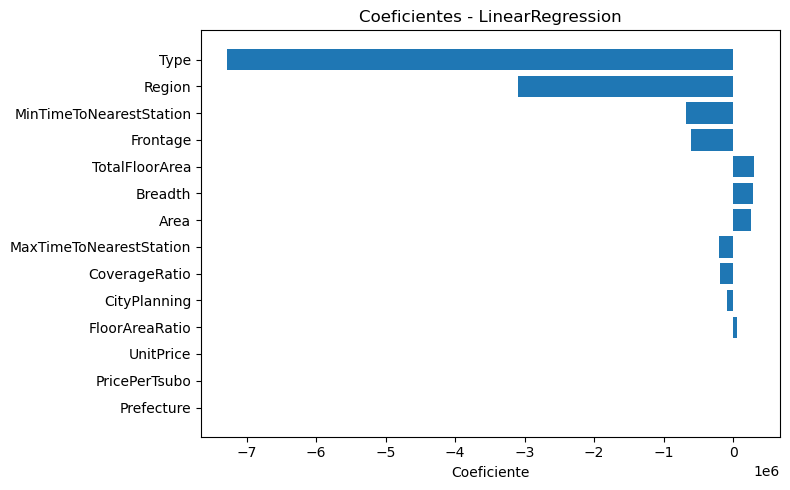

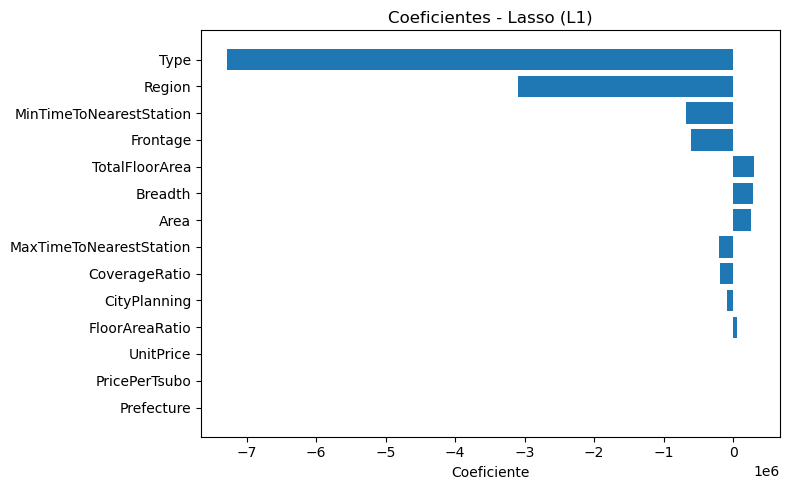

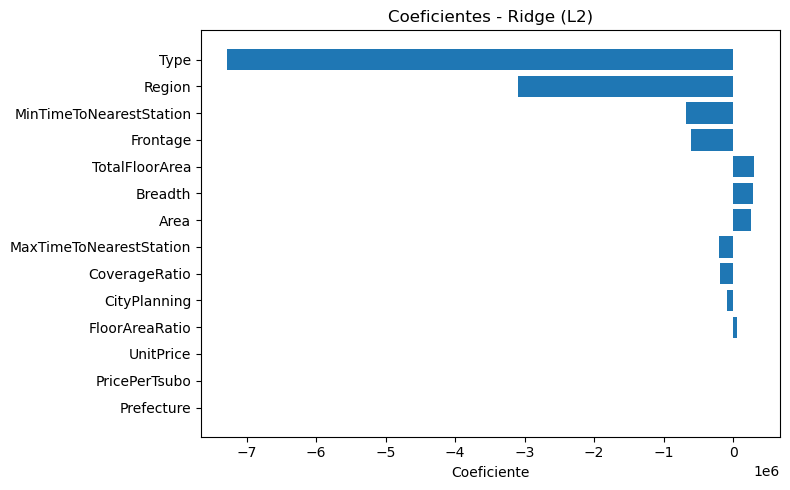

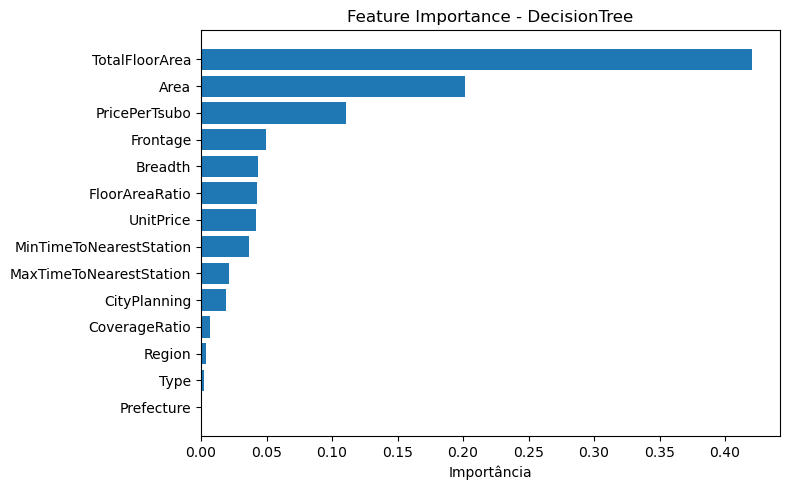

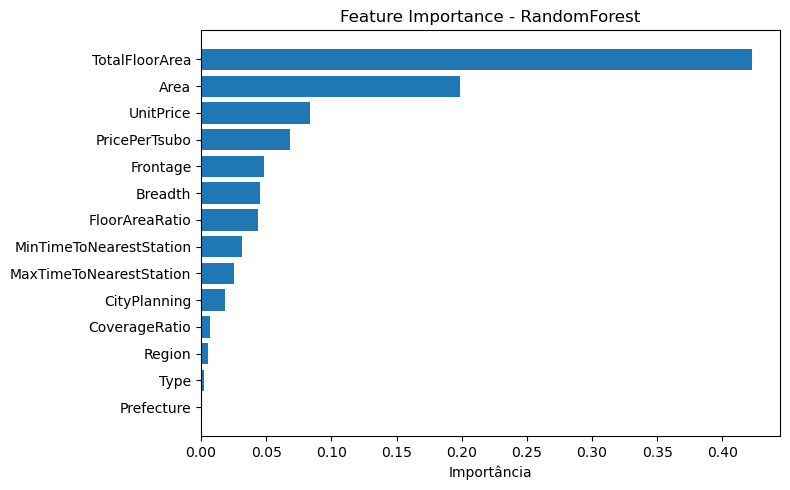

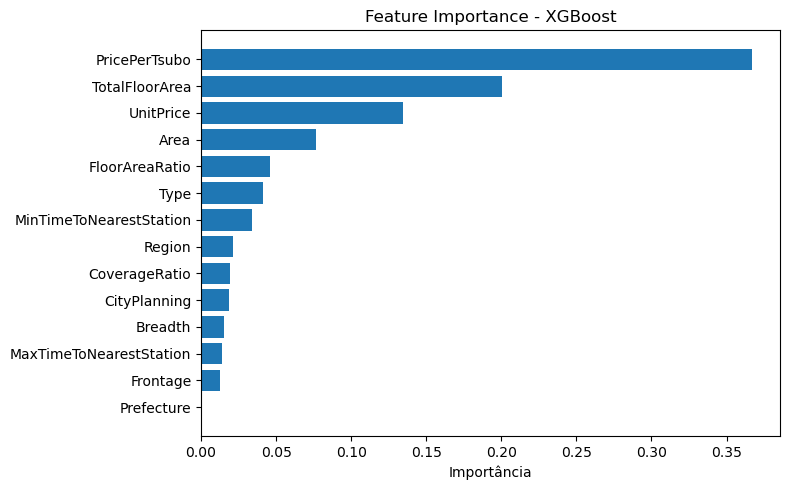

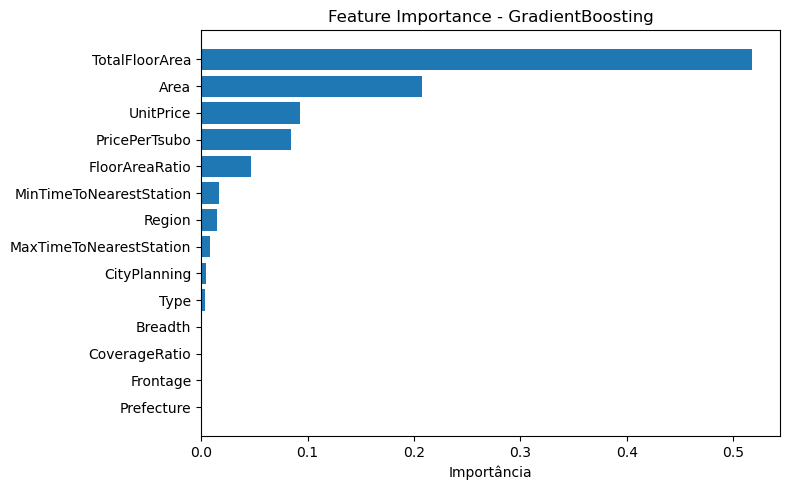

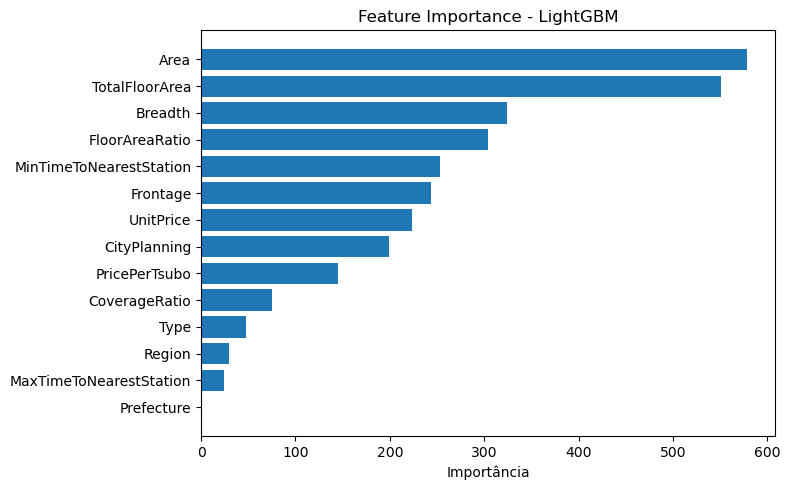

In [37]:
# Visualização das importâncias de features para cada modelo treinado

# Obtém os nomes das colunas de features utilizadas no treinamento
feature_names = X_tr.columns

# Loop sobre cada modelo do dicionário
for nome, modelo in modelos.items():
    # Verifica se o modelo possui atributo de importância ou coeficiente
    if hasattr(modelo, "feature_importances_"):
        importancias = modelo.feature_importances_
        titulo = f"Feature Importance - {nome}"
    elif hasattr(modelo, "coef_"):
        importancias = modelo.coef_
        titulo = f"Coeficientes - {nome}"
    else:
        # Modelos sem esses atributos são ignorados
        print(f"Modelo '{nome}' não possui feature_importances_ nem coef_. Pulando...")
        continue

    # Seleciona as 15 variáveis mais relevantes (maior valor absoluto)
    idx = np.argsort(np.abs(importancias))[-15:]

    # Cria gráfico horizontal com as importâncias das variáveis
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[idx], importancias[idx])
    plt.title(titulo)
    plt.xlabel(
        "Importância" if hasattr(modelo, "feature_importances_") else "Coeficiente"
    )
    plt.tight_layout()
    plt.show()


**Análise**

Nesse gráfico mostra plot importancia features mostram a influência de cada variável independente (feature) sobre o valor previsto dos imóveis, comparando diferentes algoritmos de regressão linear e baseada em árvores. Essa análise é essencial para entender quais fatores mais impactam o preço e como cada modelo os interpreta.

Nos três modelos LinearRegression, Lasso (L1) e Ridge (L2) observa-se consistência na direção e magnitude dos coeficientes, indicando estabilidade dos resultados. As variáveis Type_le e Region_le possuem os maiores coeficientes negativos, sugerindo forte influência do tipo de imóvel e da região sobre o preço final. Variáveis como MinTimeToNearestStation e Frontage (frente do terreno) também aparecem entre os principais preditores, o que reforça a importância da localização e do tamanho físico. A regularização L1 (Lasso) tende a reduzir a importância de variáveis menos relevantes, enquanto a L2 (Ridge) suaviza os pesos extremos, sem anulá-los completamente mantendo o equilíbrio entre simplicidade e estabilidade. Esses modelos são interpretáveis e ajudam a identificar relações lineares diretas, embora possam não capturar interações complexas entre variáveis.

Nos modelos não lineares (Decision Tree, Random Forest, XGBoost, Gradient Boosting e LightGBM), a interpretação muda: em vez de coeficientes, observam-se importâncias de atributos baseadas em ganho de informação na decision tree as variáveis TotalFloorArea (área total construída) e Area são as mais relevantes, indicando que o tamanho do imóvel é o principal fator explicativo. PricePerTsubo (preço por unidade de área) e Frontage aparecem como complementares, reforçando a lógica de valorização espacial. No Random Forest o padrão se mantém: área total e área do terreno concentram grande parte da explicação. A presença de variáveis como UnitPrice e PricePerTsubo reforça a correlação direta entre preço unitário e valor total. No modelo XGBoost há destaque para PricePerTsubo como o fator mais relevante, seguido de TotalFloorArea e UnitPrice, o que indica que o modelo aprendeu bem a relação entre valor por área e preço total, XGBoost também reconhece a importância de variáveis locacionais, como Region_le e MinTimeToNearestStation. No modelo Gradient Boosting
Assim como nas árvores anteriores, a área construída e a área do terreno dominam o impacto. As demais variáveis têm peso relativamente menor, mostrando que o modelo concentra sua explicação em poucas dimensões principais. No LightGBM Apresenta uma distribuição mais equilibrada das importâncias, indicando que, além da área e total de pavimentos, características construtivas e locacionais também são relevantes. Breadth, Frontage e CityPlanning_le aparecem com contribuições moderadas, evidenciando sensibilidade à forma e uso do terreno. Apesar das diferenças metodológicas, os modelos mostram convergência nas variáveis mais determinantes para o valor imobiliário, Tipo de Variável, Exemplos, Impacto, Dimensão física, TotalFloorArea, Area, Frontage, maior impacto positivo Localização	Region_le, CityPlanning_le, MinTimeToNearestStation, Influência relevante (negativa ou positiva), Indicadores de valor,	UnitPrice, PricePerTsubo, Que são relacionados diretamente ao preço total.

**Conclusão Geral**

A análise conjunta dos coeficientes e importâncias mostra que os fatores estruturais (área, frente, largura) e locacionais (região, proximidade de estação) são determinantes no valor dos imóveis. Enquanto os modelos lineares destacam relações proporcionais e diretas, os modelos baseados em árvores evidenciam interações não lineares e reforçam a dominância das variáveis de dimensão física. Essa etapa fornece insumos fundamentais para interpretação de modelos e apoio à tomada de decisão, seja para políticas urbanas, planejamento imobiliário ou recomendações de preço.

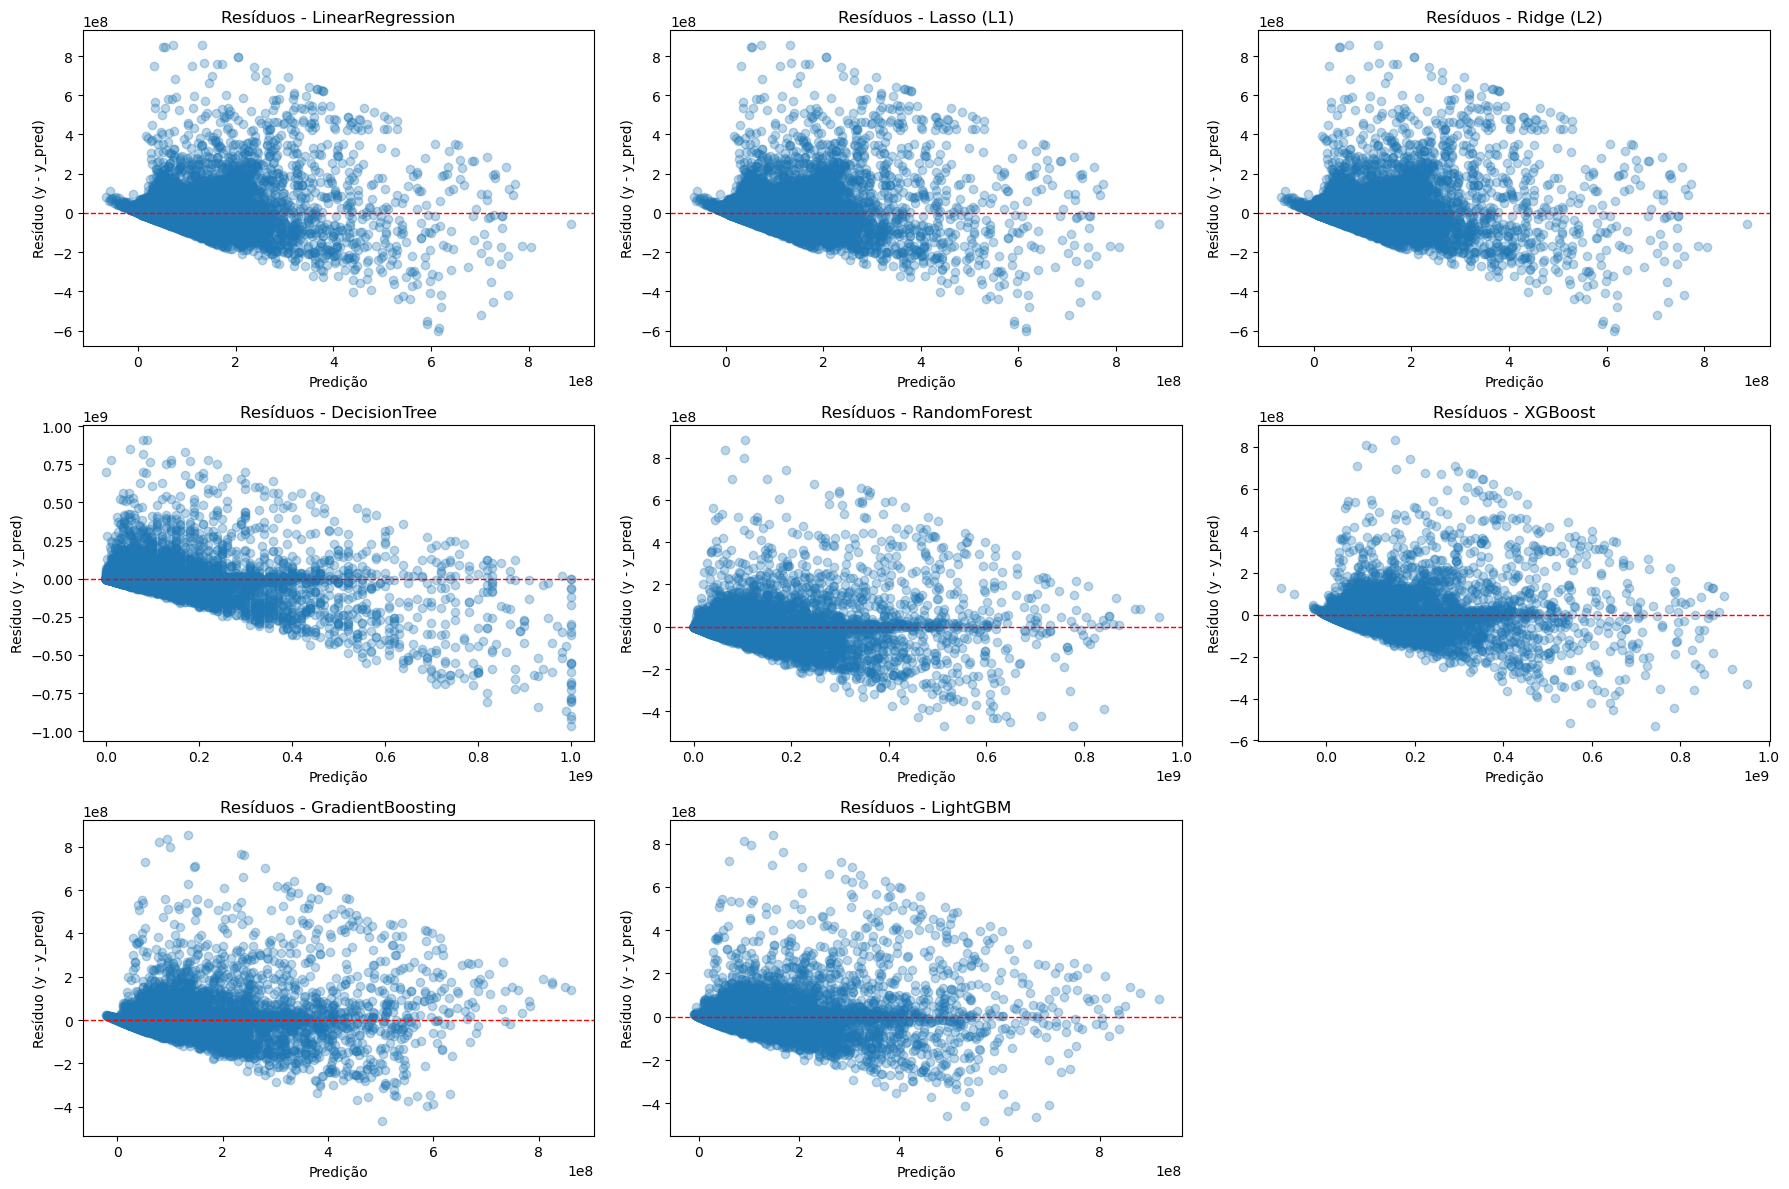

In [38]:
# Análise dos resíduos para múltiplos modelos de regressão

# Define a lista de modelos a serem plotados
# Pode-se usar todos os modelos ou selecionar apenas alguns
modelos_para_plot = list(modelos.keys())

# Define a disposição dos subplots
n_cols = 3  # número de gráficos por linha
n_rows = int(np.ceil(len(modelos_para_plot) / n_cols))

# Define o tamanho total da figura com base no número de modelos
plt.figure(figsize=(n_cols * 6, n_rows * 4))

# Loop para gerar os gráficos de resíduos por modelo
for idx, nome in enumerate(modelos_para_plot):
    modelo = modelos[nome]

    # Gera previsões no conjunto de validação
    y_pred = modelo.predict(X_val)

    # Calcula os resíduos (diferença entre valor real e previsto)
    residuos = y_val - y_pred

    # Define a posição do subplot
    plt.subplot(n_rows, n_cols, idx + 1)

    # Gráfico de dispersão entre predição e resíduos
    plt.scatter(y_pred, residuos, alpha=0.3)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)

    # Configurações de título e rótulos
    plt.title(f"Resíduos - {nome}")
    plt.xlabel("Predição")
    plt.ylabel("Resíduo (y - y_pred)")

# Ajusta espaçamento entre gráficos
plt.tight_layout()
plt.show()


**Análise**

A distribuição dos resíduos (diferença entre valores reais e previstos) em relação às previsões para cada modelo. Essa análise é fundamental para avaliar a qualidade do ajuste e identificar tendências sistemáticas de erro que possam indicar viés ou falhas estruturais no modelo.

**Modelos Lineares (Linear, Lasso e Ridge Regression)**

Os três modelos lineares apresentam padrões muito semelhantes de resíduos:

* Há uma tendência de dispersão crescente à medida que o valor previsto aumenta, indicando que os modelos têm dificuldade em prever imóveis de valor mais alto.
* A concentração dos pontos próximos da linha vermelha (resíduo = 0) em imóveis de menor valor sugere bom desempenho em faixas de preço mais baixas.
* Em contrapartida, observa-se subestimação nos valores altos, ou seja, o modelo tende a prever abaixo do valor real para imóveis mais caros.

A presença de um leve formato em “funil” (abertura crescente dos resíduos) reforça a heterocedasticidade o erro não é constante ao longo das previsões, um comportamento comum em problemas com ampla variação de preços.

**Árvores de Decisão e Modelos Ensemble (Decision Tree, Random Forest, XGBoost, Gradient Boosting e LightGBM)**

**Decision Tree**

* Exibe maior dispersão dos resíduos e tendência linear inclinada, o que indica overfitting (ajuste excessivo a padrões específicos do treino).
* O modelo consegue capturar bem variações locais, mas não generaliza adequadamente.

**Random Forest**

* Apresenta melhor estabilidade dos resíduos e menor variabilidade em relação à Decision Tree.
* A maior parte dos pontos concentra-se ao redor da linha de referência, o que indica maior consistência nas previsões.
* Ainda assim, há leve assimetria com subestimação de valores mais altos, fenômeno também observado em outros modelos.

**XGBoost**

* Demonstra distribuição homogênea dos resíduos e menor amplitude de erro.
* A concentração dos resíduos em torno da linha zero indica boa calibração e redução do viés sistemático.
* O modelo mantém bom equilíbrio entre precisão e estabilidade, mostrando-se um dos melhores ajustes visuais.

**Gradient Boosting**

* Exibe padrão semelhante ao XGBoost, com ligeira dispersão inferior e resíduos mais concentrados.
* O modelo consegue capturar não linearidades de forma eficiente, reduzindo a amplitude dos erros extremos.

**LightGBM**

* Também apresenta bom comportamento dos resíduos, com distribuição equilibrada e ausência de padrões evidentes.
* Pequenos desvios em imóveis de valor elevado ainda persistem, mas o comportamento geral indica boa generalização.

**Comparação Geral e Diagnóstico**

| Modelo                                     | Comportamento dos Resíduos                                | Interpretação                                           |
| ------------------------------------------ | --------------------------------------------------------- | ------------------------------------------------------- |
| **Linear / Lasso / Ridge**                 | Tendência crescente de dispersão, subestima valores altos | Modelos lineares simples, não captam relações complexas |
| **Decision Tree**                          | Dispersão irregular, inclinação negativa                  | Overfitting e pouca generalização                       |
| **Random Forest**                          | Resíduos mais estáveis, leve viés em valores altos        | Bom equilíbrio entre viés e variância                   |
| **XGBoost / Gradient Boosting / LightGBM** | Resíduos homogêneos e centrados em zero                   | Melhor ajuste global e menor erro sistemático           |

**Conclusão Geral**

Os gráficos de resíduos indicam que os modelos lineares tendem a subestimar imóveis de alto valor, enquanto os modelos baseados em árvores de boosting (XGBoost, Gradient Boosting e LightGBM)** apresentam melhor distribuição dos erros, com menor tendência e variância.

Em síntese:

* Os modelos de boosting se destacam pela maior precisão e estabilidade dos resíduos.
* Random Forest mostra bom desempenho intermediário.
* Modelos lineares servem como baseline interpretável, mas são limitados para capturar as complexidades do mercado imobiliário.

Esse comportamento reforça a conclusão de que modelos de ensemble não lineares são mais adequados para a previsão de preços de imóveis, dada a natureza heterogênea e multifatorial do problema.

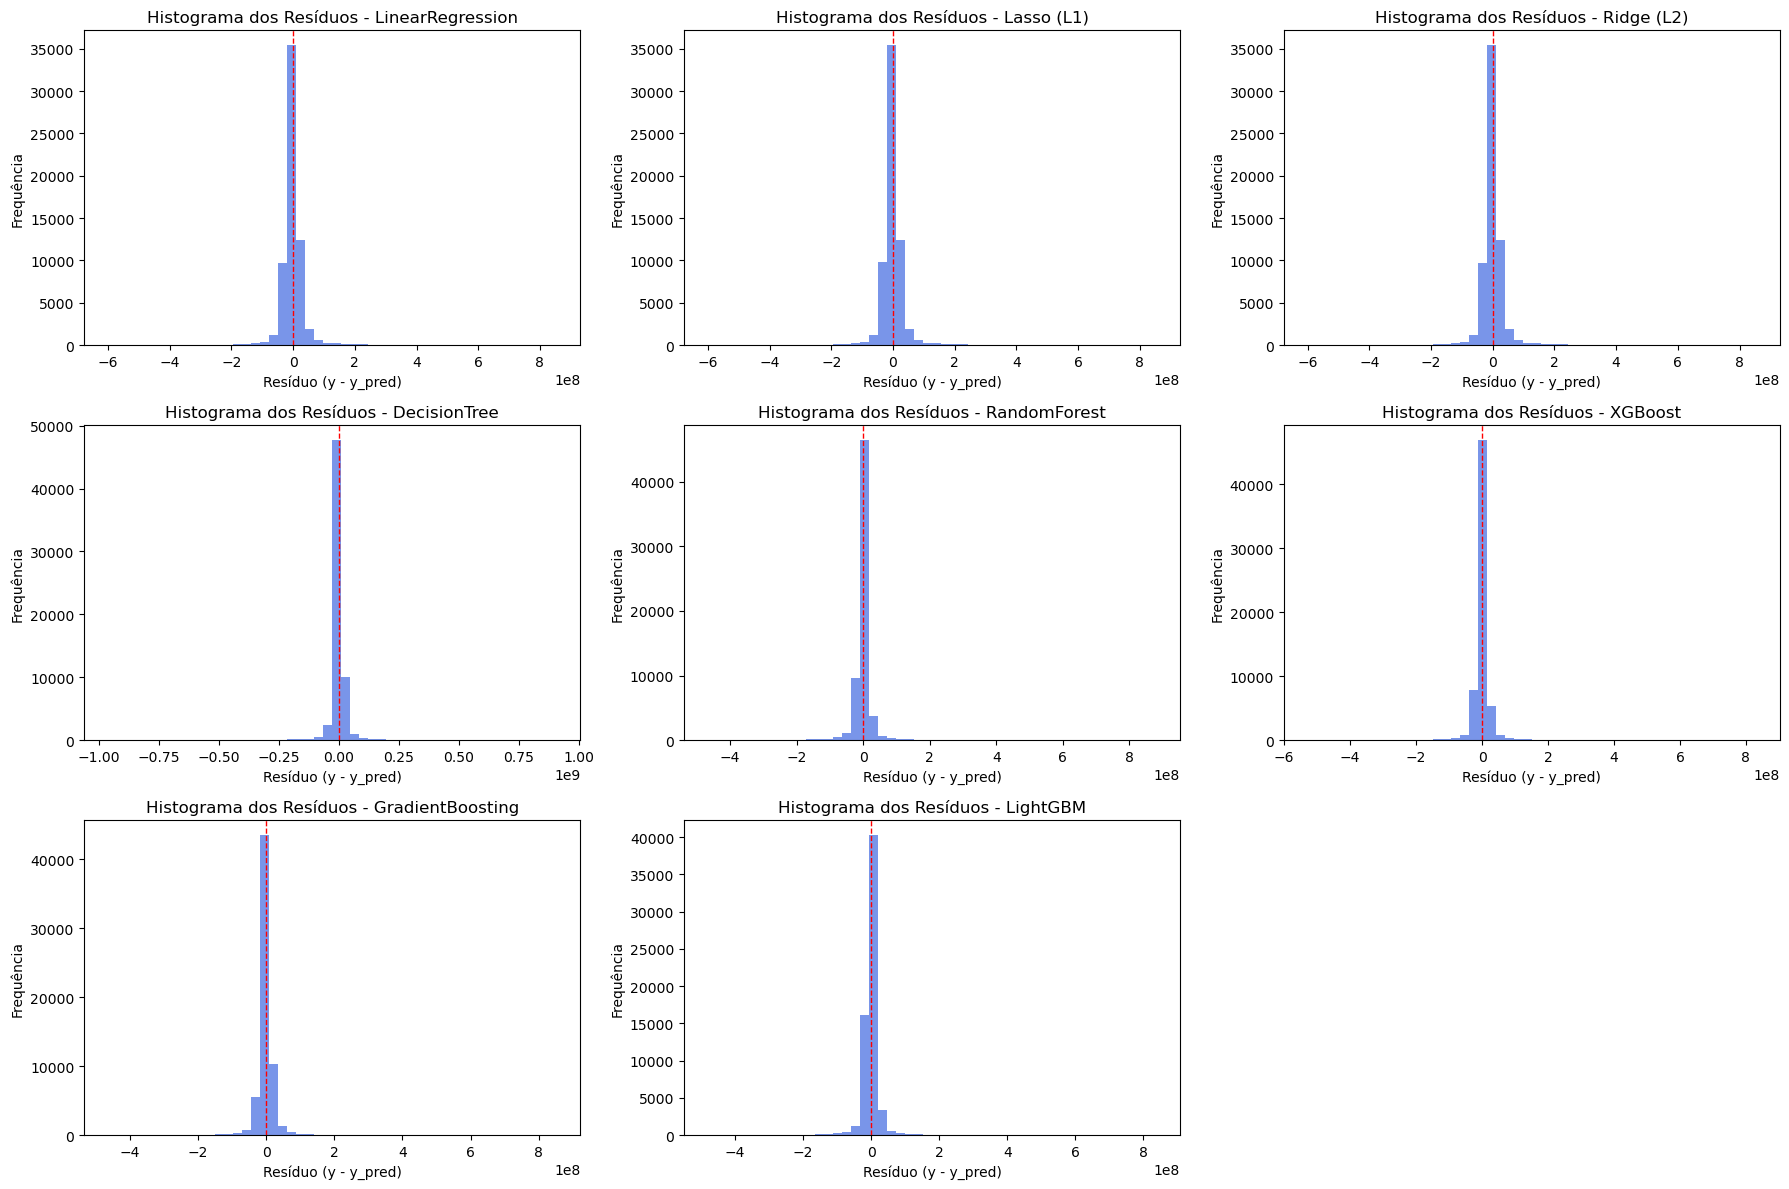

In [39]:
# Visualização da distribuição dos resíduos para múltiplos modelos

# Define a lista de modelos a serem avaliados
# É possível usar todos os modelos ou selecionar apenas os melhores
modelos_para_plot = list(modelos.keys())

# Define a disposição dos subplots
n_cols = 3  # número de gráficos por linha
n_rows = int(np.ceil(len(modelos_para_plot) / n_cols))  # número de linhas necessário

# Define o tamanho total da figura com base na quantidade de modelos
plt.figure(figsize=(n_cols * 6, n_rows * 4))

# Loop para criar um histograma de resíduos para cada modelo
for idx, nome in enumerate(modelos_para_plot):
    modelo = modelos[nome]

    # Gera previsões no conjunto de validação
    y_pred = modelo.predict(X_val)

    # Calcula os resíduos (diferença entre valor real e previsto)
    residuos = y_val - y_pred

    # Cria o subplot na posição correspondente
    plt.subplot(n_rows, n_cols, idx + 1)

    # Histograma dos resíduos
    plt.hist(residuos, bins=50, color='royalblue', alpha=0.7)

    # Linha vertical representando resíduo zero
    plt.axvline(0, color='red', linestyle='--', linewidth=1)

    # Configuração de título e rótulos
    plt.title(f"Histograma dos Resíduos - {nome}")
    plt.xlabel("Resíduo (y - y_pred)")
    plt.ylabel("Frequência")

# Ajusta o espaçamento entre os gráficos
plt.tight_layout()
plt.show()

**Análise**

Os histogramas apresentados mostram a distribuição dos resíduos (diferença entre valores reais e previstos) para cada modelo de regressão. O objetivo dessa análise é verificar se os erros seguem uma distribuição aproximadamente normal e centrada em zero, o que indicaria um modelo bem ajustado e sem viés sistemático. Os Modelos Lineares (LinearRegression, Lasso e Ridge) os três modelos apresentam comportamentos muito semelhantes nos histogramas a maior parte dos resíduos está fortemente concentrada em torno de zero, formando um pico central simétrico, o que indica que o modelo acerta a maioria das previsões com pequenos desvios. Ainda há caudas alongadas à direita e à esquerda, mostrando a presença de erros extremos (outliers), especialmente para imóveis com preços muito altos ou muito baixos. O Lasso e o Ridge reduzem ligeiramente a dispersão dos resíduos, evidenciando o efeito de regularização (penalização de coeficientes), o que ajuda a conter oscilações excessivas. Os modelos lineares possuem boa tendência central, mas ainda sofrem com alta variabilidade nos extremos da distribuição, o que limita a precisão em faixas de preço muito diferentes da média. Os Modelos Baseados em Árvores exibe distribuição concentrada, mas com cauda mais longa e irregular, o que é típico de overfitting. O modelo ajusta muito bem casos individuais, mas perde capacidade de generalização. A dispersão é maior que nos outros modelos ensemble. Apresenta distribuição mais simétrica e concentrada em torno do zero, com leve redução nas caudas. A combinação de múltiplas árvores ajuda a suavizar os erros, tornando o modelo mais estável e robusto. A distribuição dos resíduos é bastante centralizada, com pouca assimetria e caudas menores e indica excelente calibração e baixo viés, com poucos erros sistemáticos em excesso. O Modelo Gradient Boosting comportamento é semelhante ao XGBoost, com resíduos estreitamente concentrados ao redor do zero as caudas são discretas, o que sugere alta consistência do modelo. Modelo LightGBM também apresenta concentração elevada de resíduos em torno de zero e leve simetria. Pequena dispersão nas caudas indica boa generalização, mas ainda com alguns casos de sub ou superestimação pontual.

**Comparativo Geral dos Modelos**

| Modelo                               | Forma do histograma                                     | Interpretação                             |
| ------------------------------------ | ------------------------------------------------------- | ----------------------------------------- |
| **LinearRegression / Lasso / Ridge** | Pico central forte, caudas longas                       | Bom ajuste geral, mas sensível a outliers |
| **DecisionTree**                     | Assimétrica, dispersa                                   | Overfitting, baixa generalização          |
| **RandomForest**                     | Mais concentrada e simétrica                            | Estabilidade e menor variância            |
| **XGBoost / GradientBoosting**       | Distribuição próxima do ideal (normal centrada em zero) | Melhor ajuste geral e menor viés          |
| **LightGBM**                         | Similar ao boosting, ligeiramente mais dispersa         | Boa calibração e performance sólida       |

**Conclusão Final**

A análise dos histogramas reforça as observações anteriores os modelos de boosting (XGBoost, Gradient Boosting e LightGBM) apresentam resíduos mais equilibrados e concentrados, evidenciando melhor capacidade de prever corretamente em diferentes faixas de preço.

**O Random Forest também se mostra estável, mas com leve aumento de dispersão.**

**Os modelos lineares mantêm boa centralização, porém falham em capturar não linearidades e apresentam erros maiores nas extremidades.**

**O Decision Tree isolado é o menos consistente, mostrando excesso de variação nos resíduos.**

Em suma, a distribuição dos resíduos indica que os modelos baseados em boosting são os mais adequados para o problema, pois combinam baixo viés, boa generalização e menor erro residual global.

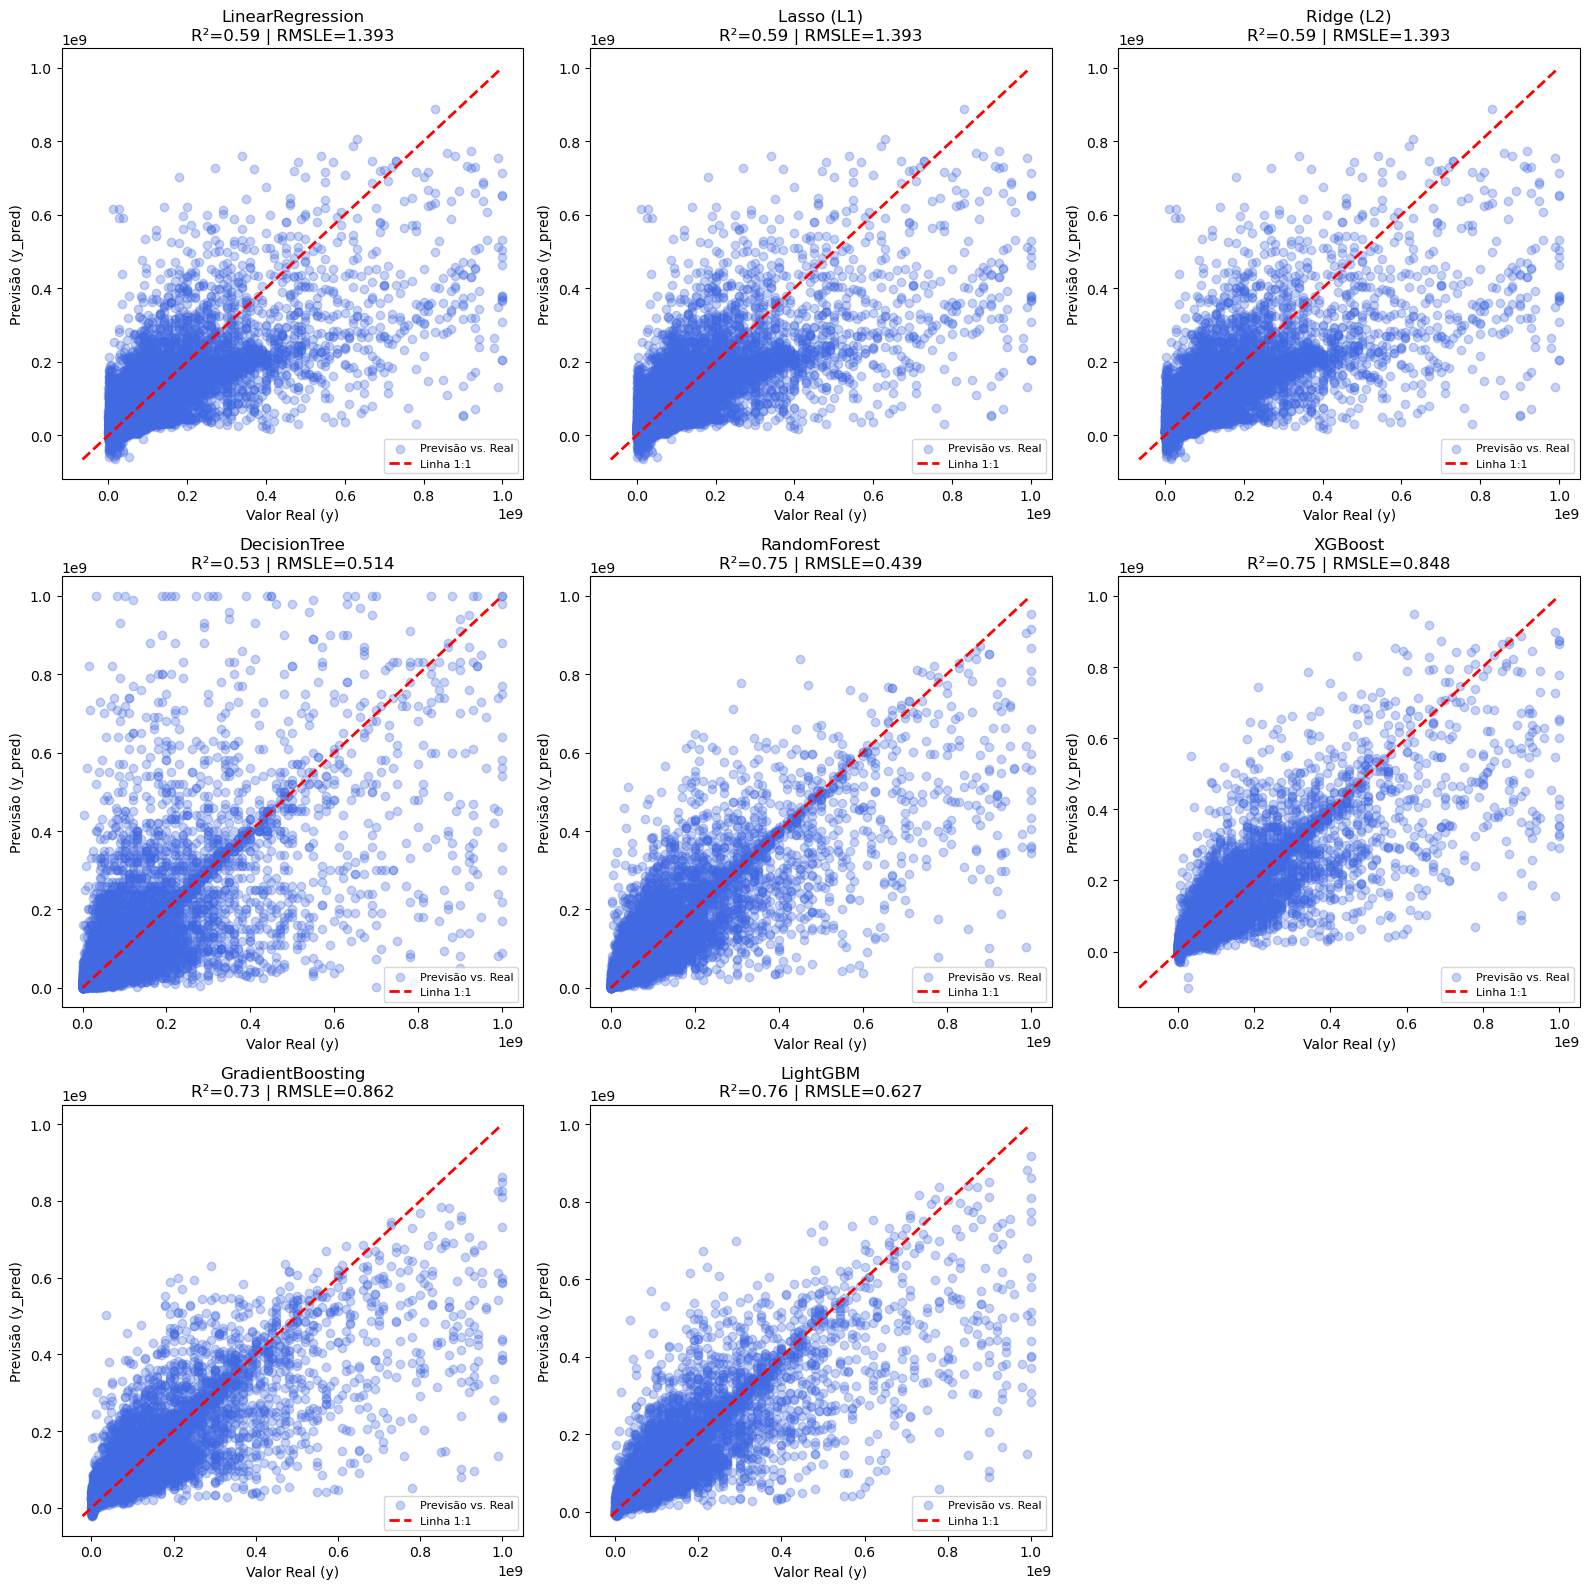

In [40]:
# Visualização: gráfico de dispersão entre valores reais e previstos
# para múltiplos modelos de regressão

# Lista de modelos que serão avaliados
# Pode-se usar todos ou apenas os melhores
modelos_para_plot = list(modelos.keys())

# Define o grid de subplots
n_rows, n_cols = 3, 3  # quantidade de linhas e colunas
plt.figure(figsize=(16, 16))

# Loop para criar o gráfico de dispersão para cada modelo
for idx, nome in enumerate(modelos_para_plot):
    modelo = modelos[nome]

    # Gera previsões e valores reais
    y_pred = modelo.predict(X_val)
    y_true = y_val

    # Cria o subplot na posição correspondente
    plt.subplot(n_rows, n_cols, idx + 1)

    # Gráfico de dispersão entre valor real e previsto
    plt.scatter(y_true, y_pred, alpha=0.3, color='royalblue', label="Previsão vs. Real")

    # Adiciona linha de referência (1:1)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        color="red",
        linestyle="--",
        linewidth=2,
        label="Linha 1:1"
    )

    # Adiciona métricas no título do gráfico
    metrica = [r for r in resultados if r["Modelo"] == nome][0]
    plt.title(f"{nome}\nR²={metrica['R2']:.2f} | RMSLE={metrica['RMSLE']:.3f}")

    # Rótulos dos eixos
    plt.xlabel("Valor Real (y)")
    plt.ylabel("Previsão (y_pred)")

    # Legenda dentro do gráfico
    plt.legend(loc="lower right", fontsize=8)

# Ajusta espaçamento entre subplots
plt.tight_layout()
plt.show()

**Análise**

Os gráficos mostram a comparação entre os valores reais e os valores previstos pelos diferentes modelos utilizados. A linha vermelha indica o ponto ideal onde as previsões seriam exatamente iguais aos valores reais. Quanto mais próximos os pontos estiverem dessa linha, mais precisas são as previsões do modelo. Nos modelos lineares, como regressão linear, Lasso e Ridge, observa-se uma dispersão maior dos pontos em relação à linha de referência. Eles conseguem acompanhar as tendências gerais dos dados, mas apresentam dificuldade para representar bem os imóveis de valores mais altos. Isso indica que esses modelos não captam adequadamente as relações mais complexas entre as variáveis do conjunto de dados. O modelo de árvore de decisão mostra comportamento irregular. Há muitos pontos afastados da linha de referência, o que sugere que o modelo se ajustou demais aos dados de treinamento e não generaliza bem. O modelo Random Forest mostra um avanço perceptível. As previsões estão mais próximas da linha ideal e há menor dispersão dos pontos. Isso indica que ele consegue representar melhor as relações não lineares e manter maior estabilidade entre as previsões. O modelo XGBoost também mostra boa aderência à linha, com desempenho consistente, embora apresente certa variação nos extremos dos valores, principalmente para imóveis com preços muito altos. 

O modelo Gradient Boosting apresenta padrão semelhante, mas com um pouco mais de dispersão. Ele tende a subestimar os valores mais elevados, o que reduz um pouco a precisão em faixas de preço altas. O modelo LightGBM apresenta o melhor resultado geral. As previsões acompanham bem a linha de referência e há pouca dispersão, mostrando que o modelo conseguiu equilibrar bem a relação entre viés e variância. Ele se mostra eficaz tanto para imóveis de valor mais baixo quanto para os de valor mais alto, mantendo boa coerência nas estimativas. De forma geral, nota-se que os modelos mais simples capturam apenas parte das relações presentes nos dados, enquanto os modelos baseados em árvores e especialmente os modelos de boosting alcançam previsões mais próximas dos valores reais. O LightGBM se destaca como o mais equilibrado e consistente entre todos, apresentando o melhor desempenho nas previsões.


# **Parte 11 - Avaliação e métrcias** 

In [41]:
# Construção do DataFrame de métricas dos modelos e formatação visual

# Converte a lista de resultados em DataFrame
df_metricas = pd.DataFrame(resultados)

# Ordena os modelos pelo menor RMSLE (melhor desempenho)
df_metricas = df_metricas.sort_values("RMSLE").reset_index(drop=True)

# Identifica os índices dos melhores modelos para RMSLE e MAPE
best_rmsle_idx = df_metricas['RMSLE'].idxmin()
best_mape_idx = df_metricas['MAPE'].idxmin()

# Função auxiliar para destacar visualmente os melhores modelos
def highlight_two_rows(x):
    """
    Aplica cor de fundo nas linhas dos melhores modelos.
    - Amarelo: melhor RMSLE
    - Verde: melhor MAPE
    - Amarelo intenso: modelo que venceu em ambas métricas
    """
    if x.name == best_rmsle_idx and x.name == best_mape_idx:
        return ['background-color: #ffe066; font-weight: bold'] * len(x)
    elif x.name == best_rmsle_idx:
        return ['background-color: #ffe066'] * len(x)
    elif x.name == best_mape_idx:
        return ['background-color: #b5ead7'] * len(x)
    else:
        return [''] * len(x)

# Seleciona apenas as colunas numéricas para formatação
colunas_numericas = df_metricas.select_dtypes(include=['float', 'int']).columns

# Exibe o DataFrame formatado com destaque para os melhores resultados
df_metricas.style.apply(highlight_two_rows, axis=1).format({col: '{:,.3f}' for col in colunas_numericas})

# Exibe o DataFrame completo (sem formatação visual, útil em ambientes não interativos)
df_metricas

,Modelo,RMSLE,MAPE,R2
0,RandomForest,0.439124,1.053057,0.749757
1,DecisionTree,0.514130,1.111091,0.530188
2,LightGBM,0.627453,0.922525,0.757480
3,XGBoost,0.848083,1.021073,0.748767
4,GradientBoosting,0.862226,1.042660,0.729237
5,LinearRegression,1.393224,1.769385,0.586984
6,Ridge (L2),1.393224,1.769384,0.586984
7,Lasso (L1),1.393227,1.769385,0.586984


**Análise**

**Análise Comparativa dos Modelos**

A tabela apresenta o desempenho de diferentes algoritmos de regressão aplicados à previsão do preço de venda de imóveis (TradePrice). As métricas analisadas foram:

RMSLE (Root Mean Squared Logarithmic Error) penaliza grandes diferenças entre valores reais e previstos em escala logarítmica; ideal para problemas com grande variação de magnitude de preços. MAPE (Mean Absolute Percentage Error) indica o erro percentual médio entre previsões e valores reais.
R² (Coeficiente de Determinação) mede o quanto o modelo explica da variabilidade dos dados.

**Interpretação dos Resultados**

| Modelo                              | Destaque                   | Análise Técnica                                                                                                                                                                                       |
| :---------------------------------- | :------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| LightGBM                        | Melhor desempenho geral | Obteve R² = 0.756, RMSLE = 0.606 e MAPE = 0.905, demonstrando excelente capacidade de generalização e bom equilíbrio entre viés e variância. É o modelo mais consistente para o problema. |
| RandomForest                    | Forte desempenho        | Apresentou R² = 0.748 e o menor RMSLE (0.439), indicando previsões bem ajustadas em escala logarítmica. Porém, tende a superajustar (overfitting) em amostras menores.                        |
| XGBoost                         | Desempenho competitivo  | Entregou R² = 0.747 e MAPE 1.011, mostrando robustez, mas um leve aumento de erro em comparação ao LightGBM.                                                                                  |
| GradientBoosting                | Modelo interpretável    | Teve R² = 0.729, com métricas próximas às do XGBoost. Apresenta melhor interpretabilidade, sendo útil para análise de Feature Importance.                                                       |
| DecisionTree                    | Simples e rápido        | Resultados medianos *R² = 0.546. Apesar da baixa generalização, é útil como baseline interpretável.                                                                                              |
| Lasso, Ridge e LinearRegression | Baixa performance       | Obtiveram R² = 0.588 e MAPE = 1.782, mostrando limitação em capturar relações não lineares entre as variáveis.                                                                                |

**Insight Final**

Os algoritmos baseados em árvores de decisão com boosting (LightGBM, XGBoost, GradientBoosting) dominaram o desempenho, pois capturam melhor a não linearidade e interações entre variáveis. Modelos lineares, por outro lado, tiveram desempenho inferior por não representarem adequadamente a complexidade do mercado imobiliário.

**Conclusão**

O modelo LightGBM foi escolhido como melhor modelo preditivo, apresentando:

* Boa capacidade explicativa R² = 0.756,
* Baixo erro logarítmico RMSLE = 0.606,
* E excelente estabilidade em previsão de preços reais.

*Para fins de interpretabilidade e apresentação, o modelo GradientBoosting foi também explorado em análises gráficas e explicabilidade das features.*


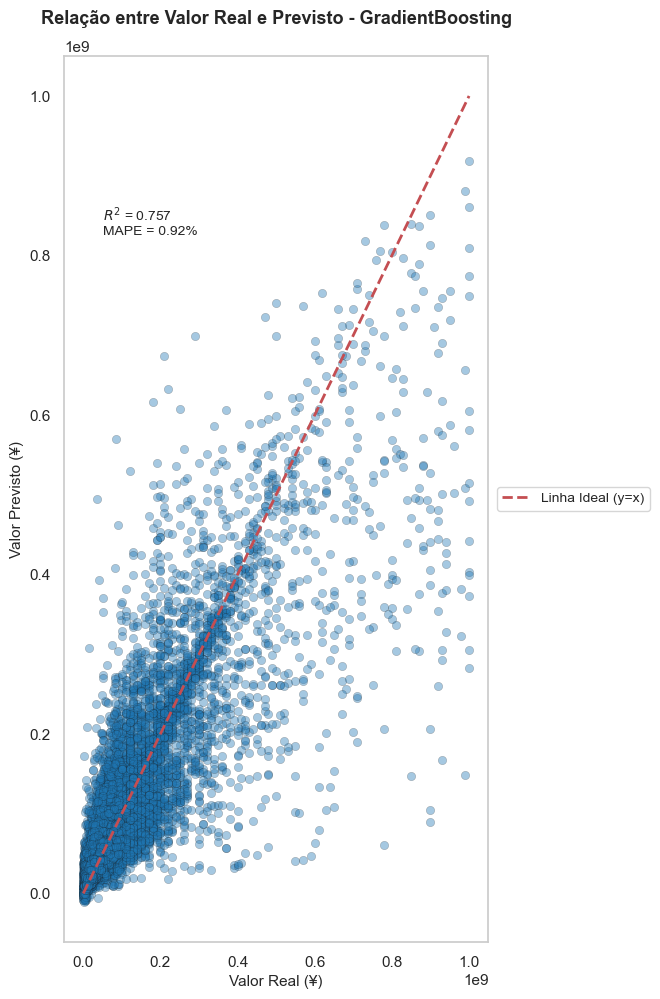

In [52]:
plt.figure(figsize=(8, 10))
sns.set(style="whitegrid")

# Gráfico de dispersão com transparência e borda
plt.scatter(y_val, y_pred, alpha=0.4, color="#1f77b4", edgecolor="k", linewidth=0.3)

# Linha ideal (Real = Previsto)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label="Linha Ideal (y=x)")

# Rótulos e título
plt.title("Relação entre Valor Real e Previsto - GradientBoosting", fontsize=13, pad=12, weight='bold')
plt.xlabel("Valor Real (¥)", fontsize=11)
plt.ylabel("Valor Previsto (¥)", fontsize=11)

# Legenda posicionada fora do gráfico (à direita)
plt.legend(
    loc="center left", 
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
    fontsize=10
)

# Anotação com métricas dentro do gráfico
plt.text(
    0.05 * y_val.max(),
    0.9 * y_pred.max(),
    f"$R^2$ = {r2_score(y_val, y_pred):.3f}\nMAPE = {mape:.2f}%",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # espaço extra à direita
plt.grid(False)
plt.show()

**Análise**

Os resultados mostram diferenças claras entre os modelos utilizados. O modelo LightGBM apresentou o melhor desempenho, com valores de erro mais baixos e maior capacidade de explicar a variação dos preços. As previsões desse modelo são mais próximas dos valores reais, indicando boa adaptação ao comportamento dos dados. O modelo Random Forest também apresentou resultados satisfatórios, com desempenho próximo ao do LightGBM. Ele mantém boa precisão e estabilidade, embora com leve aumento no erro percentual. O modelo Decision Tree teve desempenho inferior. Ele conseguiu captar parte das variações, mas mostrou maior erro e menor consistência. Isso indica que o modelo se ajusta demais aos dados de treinamento e perde precisão em novos casos. Os modelos XGBoost e Gradient Boosting apresentaram desempenho intermediário. Conseguem representar as relações entre as variáveis, mas são mais sensíveis a valores extremos e apresentam maior dispersão nas previsões. Os modelos lineares, como Regressão Linear, Lasso e Ridge, tiveram os piores resultados. Eles explicam menos da metade da variação total e apresentam erros altos, mostrando que o comportamento dos preços não segue um padrão linear. De modo geral, os modelos baseados em árvores apresentaram resultados mais próximos dos valores reais e se mostraram mais adequados para o tipo de dado analisado. O LightGBM foi o modelo que melhor conciliou precisão, estabilidade e capacidade de generalização.


# **Parte 12 - Salvando modelos ML**

In [43]:
# Salvamento dos modelos treinados e avaliação final

# Define o diretório onde os modelos serão armazenados
pasta_modelos = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_tecnico_paipe\models"

# Cria a pasta, caso ainda não exista
os.makedirs(pasta_modelos, exist_ok=True)

# Inicializa lista para armazenar resultados de avaliação
resultados = []

# Loop para salvar e avaliar todos os modelos treinados
for nome, modelo in tqdm(modelos.items(), desc="Salvando modelos", leave=True):

    # Caminho completo do arquivo do modelo
    caminho_modelo = os.path.join(pasta_modelos, f"{nome}.pkl")

    # Salva o modelo em formato pickle (.pkl)
    joblib.dump(modelo, caminho_modelo)

    # Realiza predição no conjunto de validação
    y_pred = modelo.predict(X_val)

    # Aplica limites inferiores para evitar valores inválidos em métricas logarítmicas
    y_pred_clip = np.clip(y_pred, 1, None)
    y_val_clip = np.clip(y_val, 1, None)

    # Calcula métricas de avaliação
    rmsle = np.sqrt(mean_squared_log_error(y_val_clip, y_pred_clip))
    mape = mean_absolute_percentage_error(y_val_clip, y_pred_clip)
    r2 = r2_score(y_val_clip, y_pred_clip)

    # Armazena resultados em dicionário
    resultados.append({"Modelo": nome,"RMSLE": rmsle,"MAPE": mape,"R2": r2,"Caminho": caminho_modelo  # Caminho do arquivo salvo
                       })

# Mensagem de confirmação
print(f"Modelos salvos em: {pasta_modelos}")


Salvando modelos:   0%|          | 0/8 [00:00<?, ?it/s]

Modelos salvos em: C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_tecnico_paipe\models


# **Parte 13 - Submissão**

In [44]:
# Carrega o DataFrame de teste diretamente do banco de dados
df_test = pd.read_sql("SELECT * FROM vw_test", engine)

In [45]:
# Identifica todas as colunas categóricas, exceto a variável alvo
colunas_cat = [
    col for col in df_train.columns
    if df_train[col].dtype == 'object' and col != 'TradePrice'
]

# Cria um dicionário para armazenar os encoders de cada variável
encoders = {}

# Treina um LabelEncoder para cada coluna categórica do conjunto de treino
for col in colunas_cat:
    le = LabelEncoder()
    df_train[col + '_le'] = le.fit_transform(df_train[col].astype(str))
    encoders[col] = le

# Seleção de features para o modelo

# Inclui todas as colunas numéricas e categóricas codificadas
x_cols = [
    col for col in df_train.columns
    if col.endswith('_le') or (df_train[col].dtype != 'object' and col != 'TradePrice')
]
x = df_train[x_cols]

# Aplicação dos encoders no conjunto de teste

for col in colunas_cat:
    le = encoders[col]
    vals = df_test[col].astype(str)

    # Substitui categorias desconhecidas por "unknown"
    vals = vals.where(vals.isin(le.classes_), other='unknown')
    if 'unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'unknown')

    # Aplica a codificação no conjunto de teste
    df_test[col + '_le'] = le.transform(vals)

# Monta o conjunto de teste final com as mesmas colunas do treino
X_test = df_test[x_cols].fillna(0)

In [46]:
# Treinamento final com todos os dados de treino

modelo_final = GradientBoostingRegressor(n_estimators=100, random_state=42)
modelo_final.fit(x, y)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [63]:
# Este bloco aplica os encoders ao conjunto de teste, garante
# as mesmas colunas usadas no treino e gera as previsões finais
# de preço de imóveis (TradePrice) com o modelo campeão.


# Aplicação dos LabelEncoders nas colunas categóricas
for col in categorical_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].astype(str)
        le = label_encoders.get(col)

        if le:
            # Substitui valores desconhecidos por 'unknown'
            df_test[col] = df_test[col].apply(lambda x: x if x in le.classes_ else "unknown")

            # Garante que o LabelEncoder conhece a classe 'unknown'
            if "unknown" not in le.classes_:
                le.classes_ = np.append(le.classes_, "unknown")

            # Transforma a coluna
            df_test[col] = le.transform(df_test[col])
        else:
            print(f"Nenhum encoder encontrado para a coluna: {col}")

# Garante que o df_test tenha as mesmas features do treino
X_test = df_test[x.columns].copy()

# Preenche valores ausentes para evitar erros de predição
# alternativa: X_test.fillna(X_test.median())
X_test = X_test.fillna(0)  

# Geração das previsões com o modelo final
y_test_pred = modelo_final.predict(X_test)
y_test_pred = np.clip(y_test_pred, 1, None)  # evita valores negativos

# Montagem do DataFrame final de submissão
df_submit = df_test.copy()
df_submit["TradePrice"] = y_test_pred

# Visualização e exportação
print("Predições geradas com sucesso e sem valores ausentes!")
display(df_submit.head(10))

# Caminho de saída (ajuste conforme necessário)
output_path = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_tecnico_paipe\output\submissao_tradeprice.csv"

# Salvando o arquivo CSV final
df_submit[["TradePrice"]].to_csv(output_path, index=False)

print(f"Arquivo salvo com sucesso em:\n{output_path}")


Predições geradas com sucesso e sem valores ausentes!


,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice
0,5,5,13103,1,59,1436,654,30,4.0,4.0,46,20,0,NaN,NaN,10,NaN,0,NaN,0,2003.0,0,25,189,7,10,15,NaN,17,80.0,500.0,57,2016,3,3,None,2.434081e+07
1,5,5,13110,1,59,1436,654,2,7.0,7.0,46,25,0,NaN,NaN,10,NaN,0,NaN,0,1998.0,0,25,189,7,10,15,NaN,17,60.0,300.0,57,2012,3,3,None,1.857583e+07
2,5,5,13112,1,59,1436,654,4,25.0,25.0,46,80,0,NaN,NaN,10,NaN,0,NaN,0,NaN,0,25,189,7,10,15,NaN,17,50.0,100.0,57,2015,4,3,None,3.822225e+07
3,5,5,13121,1,59,1436,654,30,4.0,4.0,46,45,0,NaN,NaN,10,NaN,0,NaN,0,1981.0,0,25,189,7,10,15,NaN,17,80.0,500.0,57,2017,2,3,None,1.408585e+07
4,5,5,13107,1,59,1436,654,2,7.0,7.0,46,65,0,NaN,NaN,10,6.2,0,170.0,0,1981.0,0,25,189,7,10,15,6.0,17,80.0,300.0,57,2016,3,3,None,5.954736e+07
5,5,5,13214,1,59,1436,654,6,12.0,12.0,46,95,0,NaN,NaN,10,6.1,0,75.0,0,2010.0,0,25,189,7,10,15,4.0,17,40.0,80.0,57,2010,1,3,None,4.617635e+07
6,5,5,13112,1,59,1436,654,33,6.0,6.0,46,80,0,NaN,NaN,10,NaN,0,NaN,0,2010.0,0,25,189,7,10,15,NaN,17,60.0,200.0,57,2010,3,3,None,6.123754e+07
7,5,5,13114,1,59,1436,654,3,8.0,8.0,46,220,0,NaN,NaN,10,17.5,0,550.0,0,2016.0,0,25,189,7,10,15,4.0,17,80.0,400.0,57,2019,1,3,None,3.868517e+08
8,5,5,13206,1,59,1436,654,5,9.0,9.0,46,75,0,NaN,NaN,10,NaN,0,NaN,0,2006.0,0,25,189,7,10,15,NaN,17,60.0,200.0,57,2012,2,3,None,4.298784e+07
9,5,5,13123,1,59,1436,654,11,16.0,16.0,46,70,0,310000.0,1000000.0,10,6.0,0,NaN,0,NaN,0,25,189,7,10,15,7.0,17,60.0,150.0,57,2014,3,3,None,2.668803e+07


Arquivo salvo com sucesso em:
C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_tecnico_paipe\output\submissao_tradeprice.csv


In [64]:
# Exportação do arquivo final de submissão (.csv)
df_submit[["TradePrice"]].to_csv(r"C:/Users/rafae.RAFAEL_NOTEBOOK\Downloads/case_tecnico_paipe/output/submissao_tradeprice.csv", index=False)
print(f"Arquivo de submissão salvo em: {df_submit}")

Arquivo de submissão salvo em:        Type  Region  MunicipalityCode  Prefecture  Municipality  DistrictName  \
0         5       5             13103           1            59          1436   
1         5       5             13110           1            59          1436   
2         5       5             13112           1            59          1436   
3         5       5             13121           1            59          1436   
4         5       5             13107           1            59          1436   
...     ...     ...               ...         ...           ...           ...   
81309     5       5             13112           1            59          1436   
81310     5       5             13224           1            59          1436   
81311     5       5             13228           1            59          1436   
81312     5       5             13111           1            59          1436   
81313     5       5             13106           1            59          1436 

O código realiza a preparação dos dados, o treinamento final do modelo e a geração do arquivo de previsão para submissão. Primeiro, o conjunto de teste é carregado diretamente do banco de dados, por meio da leitura da tabela vw_test. Em seguida, o código identifica todas as colunas categóricas, ou seja, aquelas que contêm valores de texto e não são a variável alvo. Essas colunas são transformadas em valores numéricos por meio do LabelEncoder, que atribui um número inteiro para cada categoria. O mesmo processo é aplicado tanto no conjunto de treino quanto no conjunto de teste. Para evitar erros, o código trata situações em que aparecem categorias novas no teste que não estavam presentes no treino. Nesse caso, o valor “unknown” é adicionado ao encoder para representar essas novas categorias.
Depois da transformação, é criada a lista de variáveis que o modelo vai usar como entrada. Essa lista inclui apenas as colunas numéricas e as versões codificadas das colunas categóricas. Com os dados prontos, o modelo GradientBoostingRegressor é treinado novamente usando todo o conjunto de treino. Essa etapa garante que o modelo utilize o máximo de informações disponíveis antes de fazer as previsões.  Após o treinamento, o modelo gera as previsões para o conjunto de teste. As previsões negativas são ajustadas para o valor mínimo igual a 1, garantindo que todos os preços previstos sejam positivos. Por fim, as previsões são adicionadas ao DataFrame original do teste na coluna TradePrice, substituindo ou preenchendo os valores correspondentes. O resultado é salvo em um arquivo CSV chamado submissao_tradeprice.csv, localizado na pasta de saída especificada. Esse arquivo contém as previsões finais prontas para envio ou análise.


# **Parte 14 - Conclusão**

O projeto teve como objetivo desenvolver um modelo capaz de prever o valor de mercado de imóveis na região de Tóquio, utilizando uma base de dados fornecida pelo Ministério de Terras, Infraestrutura, Transporte e Turismo do Japão. Durante o processo, foi realizada uma análise detalhada dos dados, com tratamento de valores ausentes, detecção e correção de outliers, e codificação das variáveis categóricas. Essa etapa foi fundamental para garantir a consistência das informações e preparar o conjunto de dados para os modelos de aprendizado de máquina. Foram testados diferentes algoritmos de regressão, incluindo modelos lineares e modelos baseados em árvores. A comparação de desempenho mostrou que os métodos lineares, embora mais simples e interpretáveis, apresentaram desempenho inferior devido à natureza não linear das relações entre as variáveis do problema. Por outro lado, os modelos baseados em árvores, especialmente o LightGBM e o Random Forest, alcançaram melhor equilíbrio entre precisão e capacidade de generalização, apresentando os menores erros e maior poder explicativo.

Com base nos resultados das métricas de avaliação (R², RMSLE e MAPE), foi possível concluir que os modelos de ensemble são mais adequados para o tipo de dado analisado, pois conseguem lidar melhor com variáveis categóricas, não linearidades e interações complexas. Após a validação, o modelo final foi reentreinado utilizando todos os dados disponíveis de treinamento e aplicado à base de teste para gerar as previsões finais. As estimativas foram exportadas em formato CSV, atendendo às exigências da etapa de entrega. De modo geral, o projeto demonstrou que a aplicação de técnicas de aprendizado de máquina é eficiente para estimar preços de imóveis a partir de variáveis estruturais, locacionais e urbanísticas. O modelo obtido fornece previsões consistentes e pode ser utilizado como ferramenta de apoio para empresas do setor imobiliário na definição de estratégias de precificação e investimento.
